In [52]:
%matplotlib notebook

In [53]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


10.1


In [54]:
import importlib
importlib.reload(Utility)
from Utility import *

In [55]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        s.batchSize = 1
        
        s.biLaplacian = False
        s.lpSmootherW = 0.0001
        s.normalSmootherW = 0.1
        
        s.vertexFixingWeight = 100
        s.toSparseCornersFixingWeight = 1e-6
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [56]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1
# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

# cfg.plotStep = 20
cfg.plotStep = 5

cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
# cfg.learningRate = 1
# cfg.learningRate = 0.1
# cfg.learningRate = 0.1
cfg.learningRate = 1e-3

# cfg.batchSize = 2
cfg.batchSize = 4


cfg.normalShiftLevel = 10
# cfg.faces_per_pixel = 14
# cfg.faces_per_pixel = 30
cfg.faces_per_pixel = 6

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1

cfg.lpSmootherW = 0.000001
# cfg.lpSmootherW = 0.0

# cfg.normalSmootherW = 0.1
# cfg.normalSmootherW = 0.1
cfg.normalSmootherW = 0.0

renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [57]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder =  r'F:\WorkingCopy2\2020_06_04_SilhouetteExtraction\03067\silhouettes\Undist'
# modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealData\SilhouettePoseFitting_Sig1e-07_BR1e-07_Fpp5_NCams16_ImS1080_LR0.002\FinalMesh.obj'
modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataPose\SilhouettePoseFitting_Sig1e-07_BR1e-07_Fpp5_NCams16_ImS1080_LR0.002_JR1e-06\FinalMesh.obj'
sparsePointCloudFile = r'F:\WorkingCopy2\2020_05_21_AC_FramesDataToFitTo\Copied\03067\A00003067.obj'

outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\03067\SilhouettePerVertex'
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'
# compressedStorage = False
# initialFittingParamPoseFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSHFit\LadaOldSuit_WithOPKeypoints_DenseSparsePts\OptimizedPoses_ICPTriangle.npy'
# initialFittingParamBetasFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSHFit\LadaOldSuit_WithOPKeypoints_DenseSparsePts\OptimizedBetas_ICPTriangle.npy'
# initialFittingParamTranslationFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSHFit\LadaOldSuit_WithOPKeypoints_DenseSparsePts\OptimizedTranslation_ICPTriangle.npy'

compressedStorage = True
initialFittingParamFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\03067\RealDataPose\PoseFitting_HeadKP__Sig1e-07_BR1e-07_Fpp15_NCams16_ImS1080_LR0.002_JR1e-06_KPW0.0001\FittingParam.npz'

smplshData = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SmplshModel.npz'
toSparsePCMat = r'F:\WorkingCopy2\2020_06_14_FitToMultipleCams\InitialFit\PersonalModel\InterpolationMatrix.npy'
initialPersonalShapeFile = r'F:\WorkingCopy2\2020_06_14_FitToMultipleCams\InitialFit\PersonalModel\PersonalShape.npy'


In [58]:
handIndicesFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\HandIndices.json'
HeadIndicesFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\HeadIndices.json'

handIndices = json.load(open(handIndicesFile))
headIndices = json.load(open(HeadIndicesFile))

indicesToFix = copy.copy(handIndices)
indicesToFix.extend(headIndices)

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)
nVerts = smplshExampleMesh.points.shape[0]

In [59]:
LNP = getLaplacian(smplshExampleMeshFile)

np.save('SmplshRestposeLapMat.npy', LNP)

BiLNP = LNP @ LNP
if cfg.biLaplacian:
    LNP = torch.tensor(BiLNP,  dtype=torch.float32, device=device, requires_grad=False)
else:
    LNP = torch.tensor(LNP,  dtype=torch.float32, device=device, requires_grad=False)

In [60]:
# normalShift = torch.tensor(np.full((nVerts,1), 0), dtype=torch.float32, requires_grad = True, device=device)
initialPersonalShape = np.load(initialPersonalShapeFile)
xyzShift = torch.tensor(initialPersonalShape, dtype=torch.float32, requires_grad = True, device=device)

In [61]:
# load Images
image_refs_out, crops_out = load_images(imageFolder, cropSize=cfg.imgSize)
crops_out = np.stack(crops_out, axis=0)

actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())
print(crops_out.shape)

if compressedStorage:
    fitParam = np.load(initialFittingParamFile)
    transInit = fitParam['trans'] * 1000
    poseInit = fitParam['pose']
    betaInit = fitParam['beta']
else:
    transInit = np.load(initialFittingParamTranslationFile) * 1000
    poseInit = np.load(initialFittingParamPoseFile)
    betaInit = np.load(initialFittingParamBetasFile)
    
smplsh = smplsh_torch.SMPLModel(device, smplshData, personalShape=xyzShift, unitMM=True)

pose = torch.tensor(poseInit, dtype=torch.float64, requires_grad = True, device=device)
betas = torch.tensor(betaInit, dtype=torch.float64, requires_grad = True, device=device)
trans = torch.tensor(transInit, dtype=torch.float64, 
                     requires_grad = True, device=device)

verts = smplsh(betas, pose, trans).type(torch.float32)

smplshMesh = Meshes([verts], [smplsh.faces.to(device)])

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])
(16, 1080, 1080, 3)


In [62]:
# Build up the sparse point cloud constraint
interpoMat = np.load(toSparsePCMat)

registeredCornerIds = np.where(np.any(interpoMat, axis=1))[0]
print("Number of registered corners:", registeredCornerIds.shape)

sparsePC = pv.PolyData(sparsePointCloudFile)
sparsePC = np.array(sparsePC.points)

constraintIds = np.where(sparsePC[:,2] > 0)[0]
constraintIds = np.intersect1d(registeredCornerIds, constraintIds)
print("Number of constraint corners:", constraintIds.shape)

interpoMat = interpoMat[constraintIds, :]
sparsePC = sparsePC[constraintIds, :]
# initial to sparse point cloud dis

dis = sparsePC - interpoMat @ verts.cpu().detach().numpy()

sparsePC =  torch.tensor(sparsePC, dtype=torch.float32, requires_grad = False, device=device)
interpoMat = torch.tensor(interpoMat, dtype=torch.float32, requires_grad = False, device=device)

Number of registered corners: (1577,)
Number of constraint corners: (1221,)


In [63]:
np.max(dis, axis=0)

array([25.49026488, 24.63635022, 24.95296569])

In [64]:
# print("target:", sparsePC[638, :])
# print("interpolated:", (interpoMat @ verts.cpu().detach().numpy())[638, :])
# np.max(interpoMat[638, :])

In [65]:
xyzShift.shape

torch.Size([6750, 3])

In [66]:
# modifiedVerts = verts + normalShift * nNormals

mesh = Meshes(
                verts=[verts],   
                faces=[smplsh.faces.to(device)], 
#                 textures=textures.to(device)
            )

In [67]:
expName = 'XYZ_RestPose_HHFix_Sig_' + str(cfg.sigma) + '_BR' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams' + str(cfg.numCams)+ 'ImS' + str(cfg.imgSize) + "_LR" + str(cfg.learningRate) + "_LW" + str(cfg.lpSmootherW) + "_NW" + str(cfg.normalSmootherW) + '_Batch'+ str(cfg.batchSize)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump({"CfgSynth":cfg.__dict__, "CfgRef":cfgRef.__dict__,}, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\03067\SilhouettePerVertex\XYZ_RestPose_HHFix_Sig_1e-07_BR1e-07_Fpp6_NCams16ImS1080_LR0.001_LW1e-06_NW0.0_Batch4


In [68]:
def visualize2DResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                if pytorch3DImg:
                    imgAlpha = images[iCam,...,3]
                else:
                    imgAlpha = images[iCam]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam])
#                     fgMask = np.logical_not(np.where())
                    for iChannel in range(3):
                        img[..., iChannel] = np.where(imgAlpha, imgAlpha, backGroundImages[iCam][...,iChannel])
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

<IPython.core.display.Javascript object>


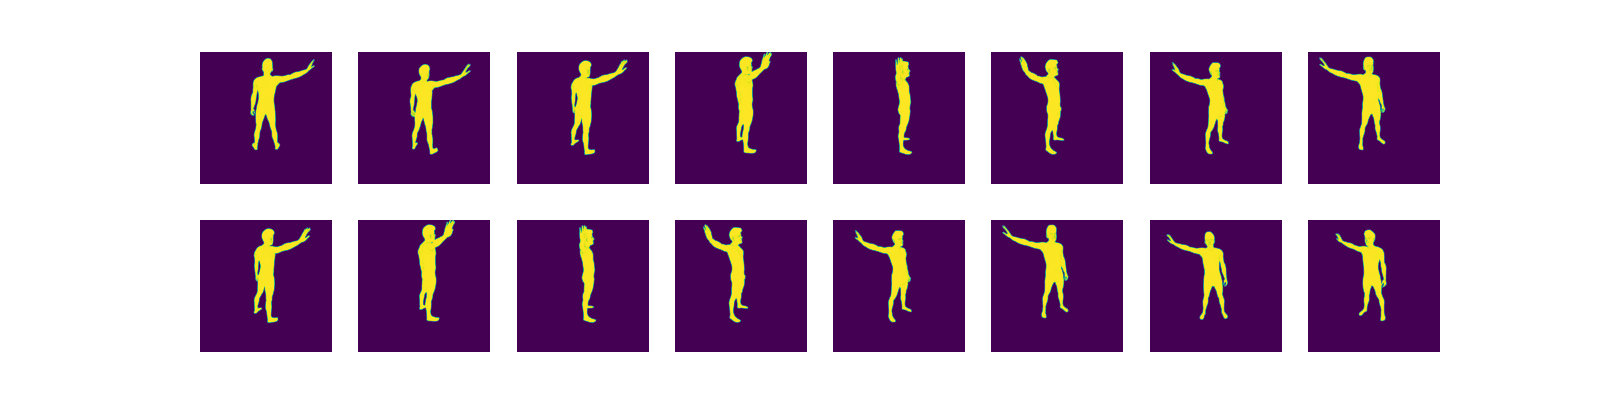

Before release: active_bytes.all.current: 3275.407872 MB
After release: active_bytes.all.current: 3275.407872 MB


In [69]:
images = None
cfg.batchSize = 4
cams = init_camera_batches(cams_torch, device, batchSize=cfg.batchSize)
with torch.no_grad():
    meshes = join_meshes_as_batch([mesh for i in range(cfg.batchSize)])
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(meshes,  cameras=cams[iCam]).cpu().detach().numpy()
        if images is not None:
            images = np.concatenate([images, image_cur], axis=0)
        else:
            images = image_cur
visualize2DResults(images)
showCudaMemUsage(device)

In [70]:
images.shape

(16, 1080, 1080, 4)

In [71]:
diffImages = None

loss = 0
for iCam in range(len(cams)):
    imagesBatchRef = crops_out[iCam*cfg.batchSize:iCam*cfg.batchSize + cfg.batchSize, ...,0]
    imagesBatch = images[iCam*cfg.batchSize:iCam*cfg.batchSize + cfg.batchSize, ...,3]
    imgDif = np.abs(imagesBatch - imagesBatchRef)
    if diffImages is not None:
        diffImages = np.concatenate([diffImages, imgDif], axis=0)
    else:
        diffImages = imgDif
    loss += 1 -np.sum(np.abs(imagesBatch * imagesBatchRef)) / np.sum(np.abs(imagesBatchRef + imagesBatch - imagesBatchRef * imagesBatch))

In [72]:
print("mesh_laplacian_smoothing", mesh_laplacian_smoothing(mesh))
print("mesh_normal_consistency", mesh_normal_consistency(mesh))

mesh_laplacian_smoothing tensor(2.7656, device='cuda:0', grad_fn=<DivBackward0>)
mesh_normal_consistency tensor(0.0555, device='cuda:0', grad_fn=<DivBackward0>)


<IPython.core.display.Javascript object>


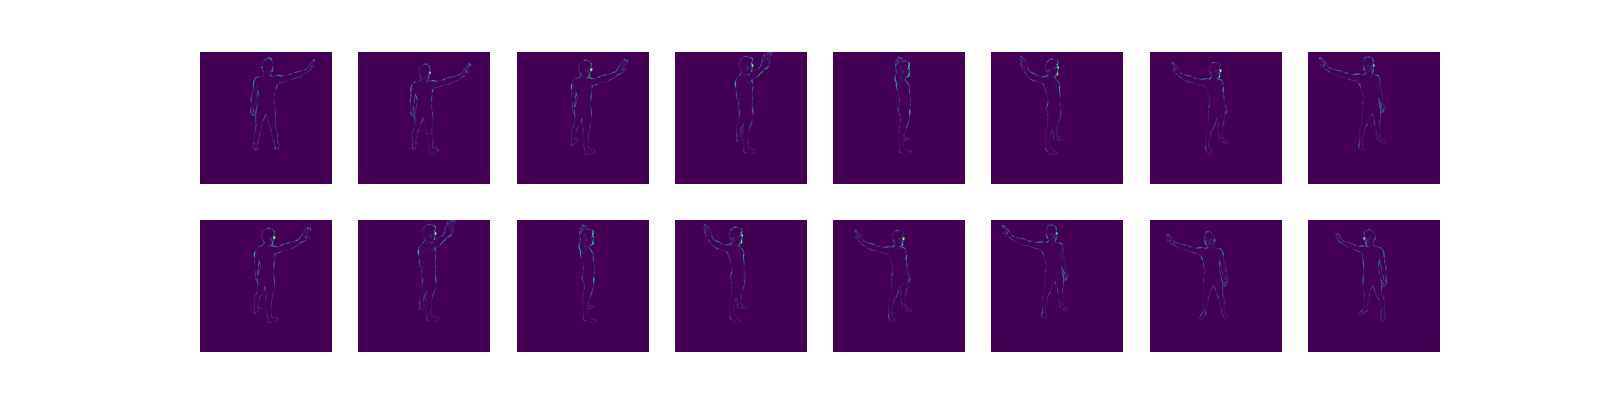

In [73]:
visualize2DResults(diffImages, pytorch3DImg=False)

In [74]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

# cfg.learningRate = 0.05
# cfg.learningRate = 0.1
# cfg.plotStep = 5
# cfg.learningRate = 3

In [75]:
optimizer = torch.optim.Adam([trans, pose, betas, xyzShift], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [76]:
torch.cuda.empty_cache()
showCudaMemUsage(device)
cams

Before release: active_bytes.all.current: 2154.82112 MB
After release: active_bytes.all.current: 2154.82112 MB


In [77]:
cfg.plotStep = 1

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


2020-06-16 17:10:59,330 logger INFO Fitting loss 0.234875, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051255, toSparseCloudLoss 0.132051, MemUsed:2228.38
2020-06-16 17:10:59,330 logger INFO Fitting loss 0.234875, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051255, toSparseCloudLoss 0.132051, MemUsed:2228.38
2020-06-16 17:10:59,330 logger INFO Fitting loss 0.234875, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051255, toSparseCloudLoss 0.132051, MemUsed:2228.38
2020-06-16 17:11:04,776 logger INFO Fitting loss 0.239723, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051223, toSparseCloudLoss 0.129112, MemUsed:2228.38
2020-06-16 17:11:04,776 logger INFO Fitting loss 0.239723, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051223, toSparseCloudLoss 0.129112, MemUsed:2228.38
2020-06-16 17:11:04,776 logger INFO Fitting loss 0.239723, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051223, 

<IPython.core.display.Javascript object>


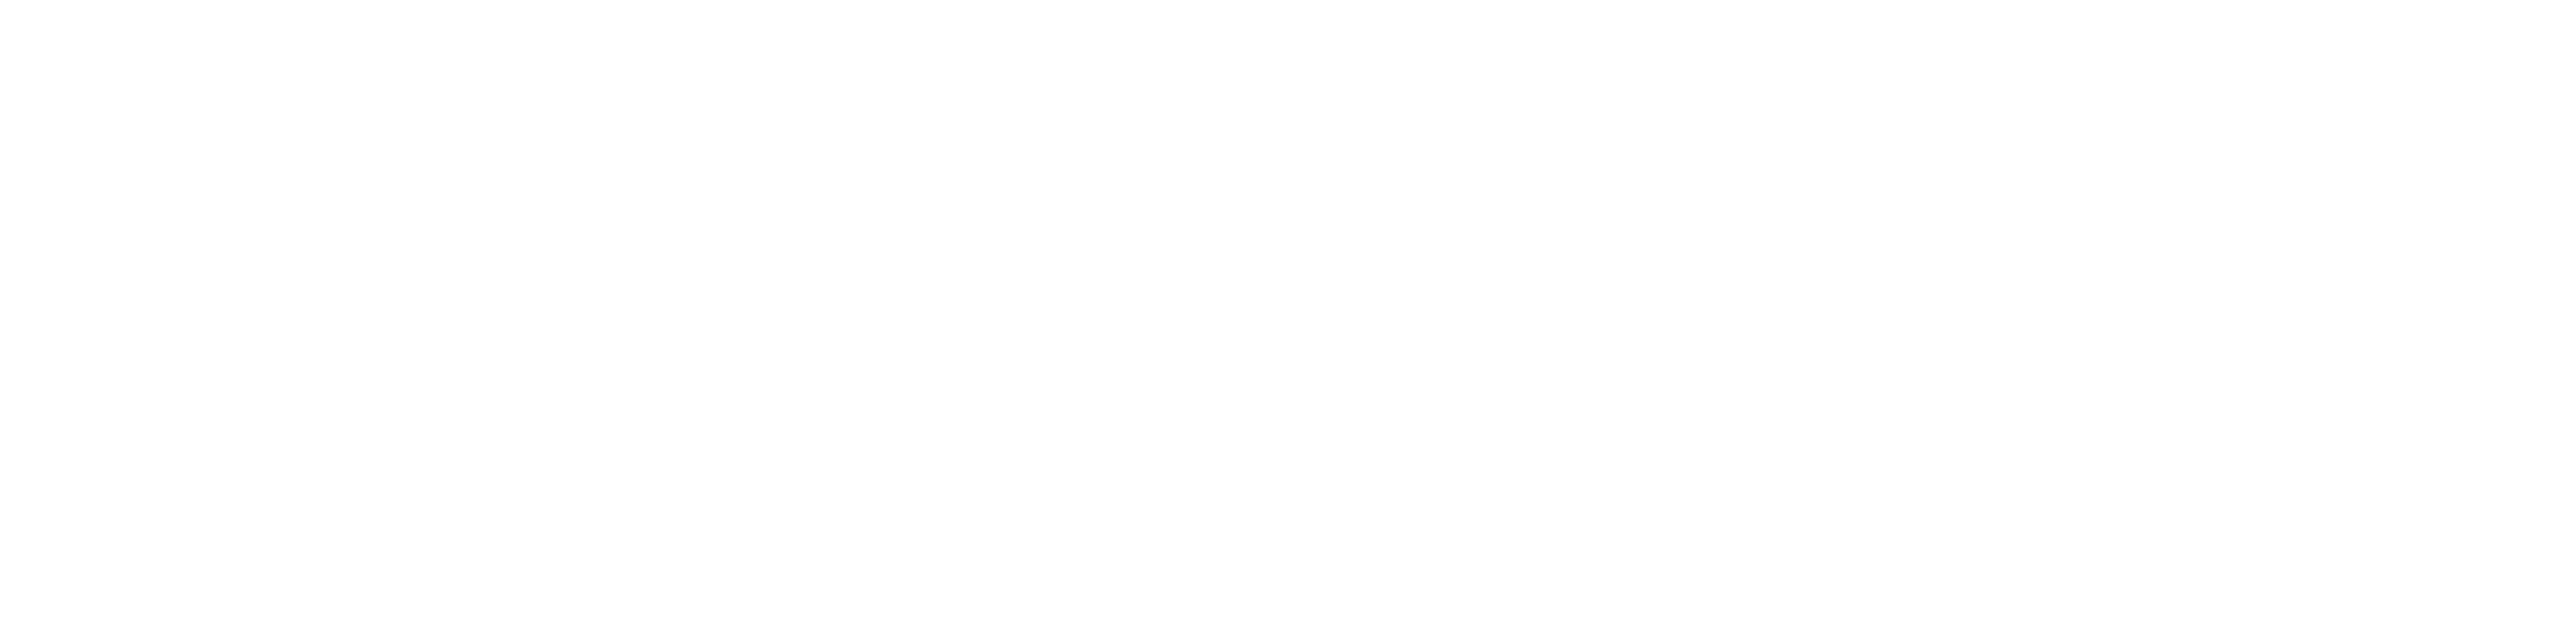

2020-06-16 17:11:27,261 logger INFO Fitting loss 0.234051, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051194, toSparseCloudLoss 0.127849, MemUsed:2228.38
2020-06-16 17:11:27,261 logger INFO Fitting loss 0.234051, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051194, toSparseCloudLoss 0.127849, MemUsed:2228.38
2020-06-16 17:11:27,261 logger INFO Fitting loss 0.234051, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051194, toSparseCloudLoss 0.127849, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


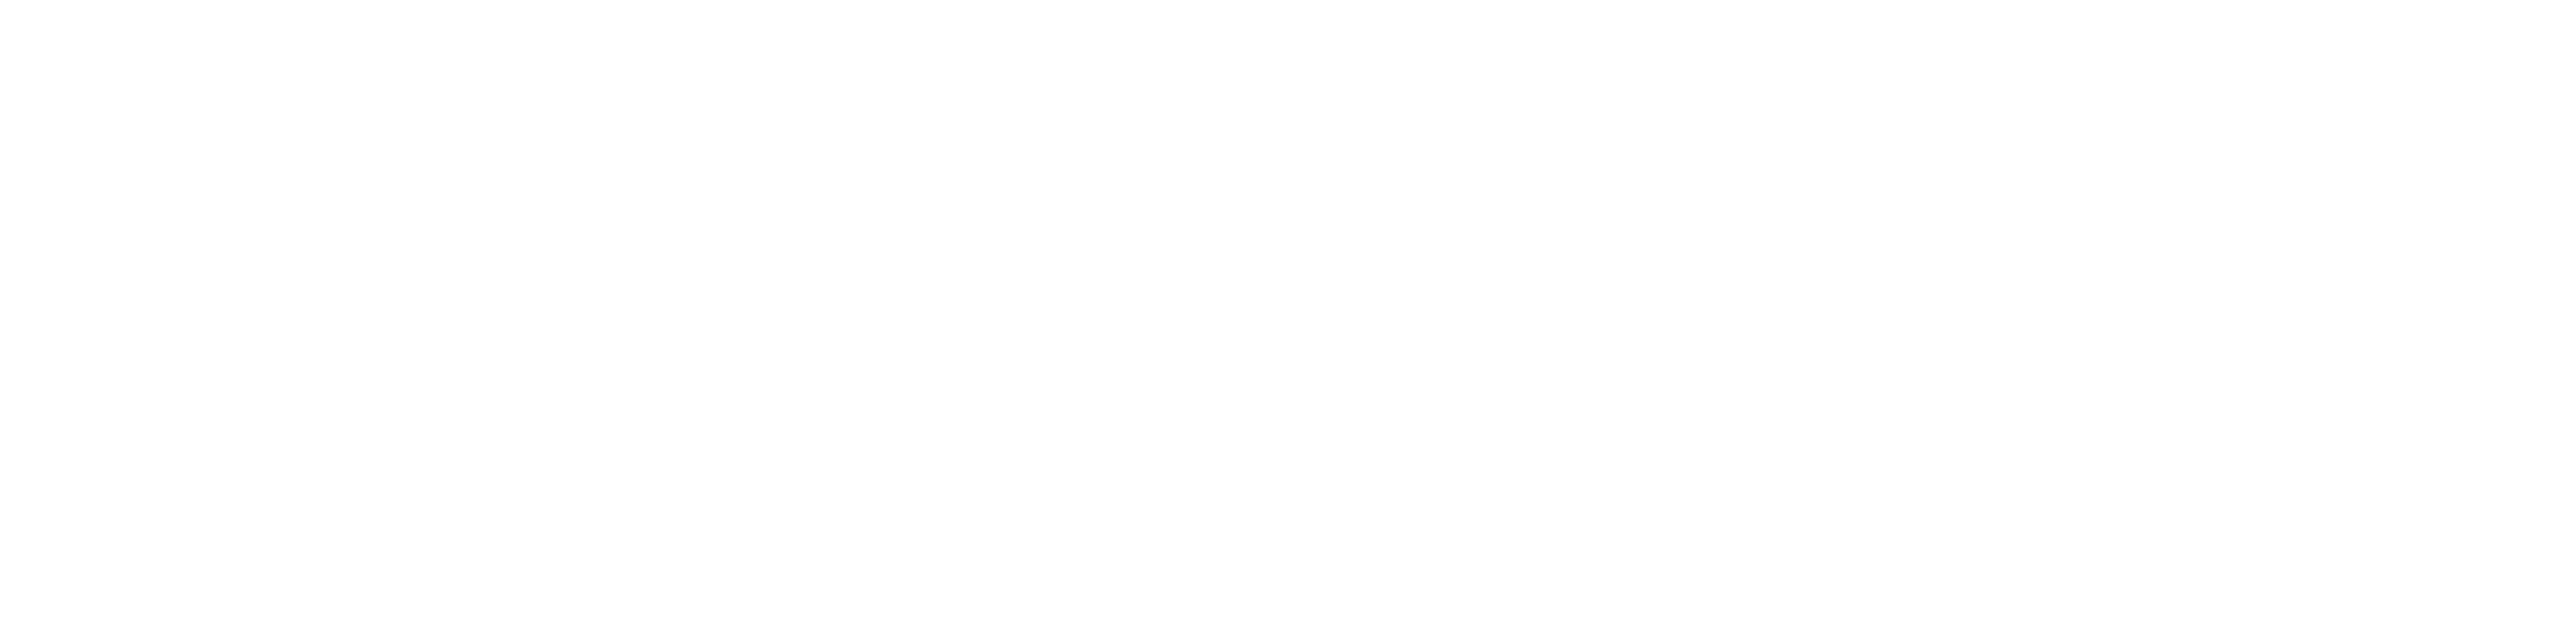

2020-06-16 17:11:49,922 logger INFO Fitting loss 0.232660, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051165, toSparseCloudLoss 0.126434, MemUsed:2228.38
2020-06-16 17:11:49,922 logger INFO Fitting loss 0.232660, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051165, toSparseCloudLoss 0.126434, MemUsed:2228.38
2020-06-16 17:11:49,922 logger INFO Fitting loss 0.232660, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051165, toSparseCloudLoss 0.126434, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


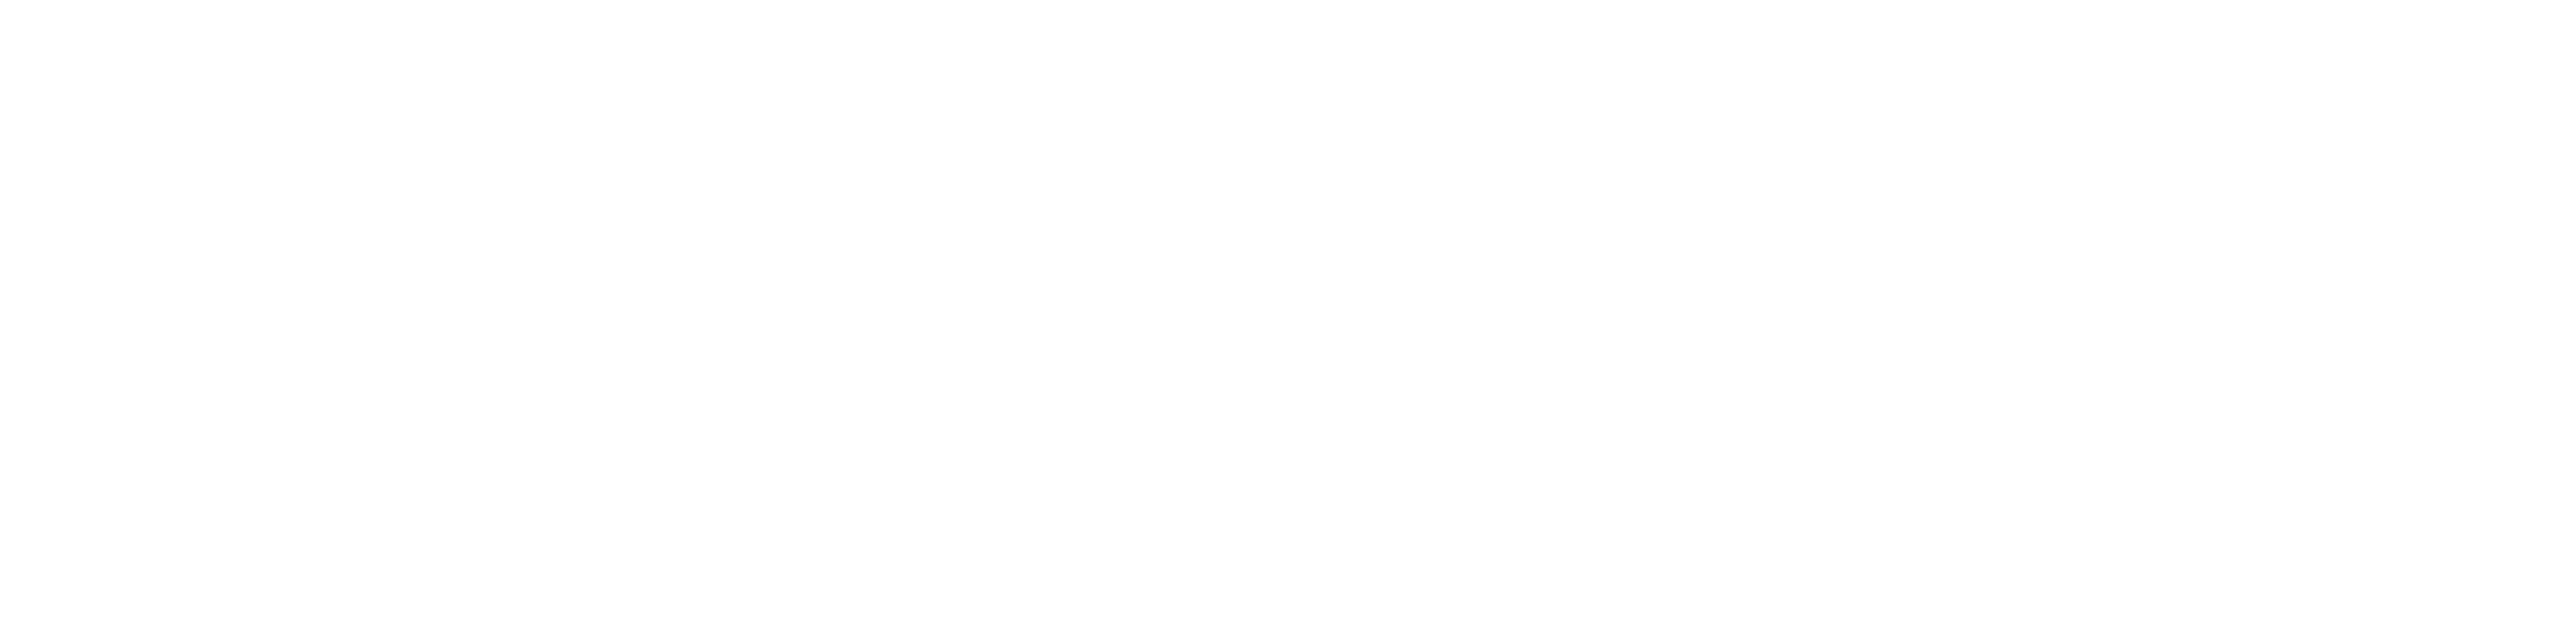

2020-06-16 17:12:12,293 logger INFO Fitting loss 0.233191, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051135, toSparseCloudLoss 0.125620, MemUsed:2228.38
2020-06-16 17:12:12,293 logger INFO Fitting loss 0.233191, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051135, toSparseCloudLoss 0.125620, MemUsed:2228.38
2020-06-16 17:12:12,293 logger INFO Fitting loss 0.233191, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051135, toSparseCloudLoss 0.125620, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


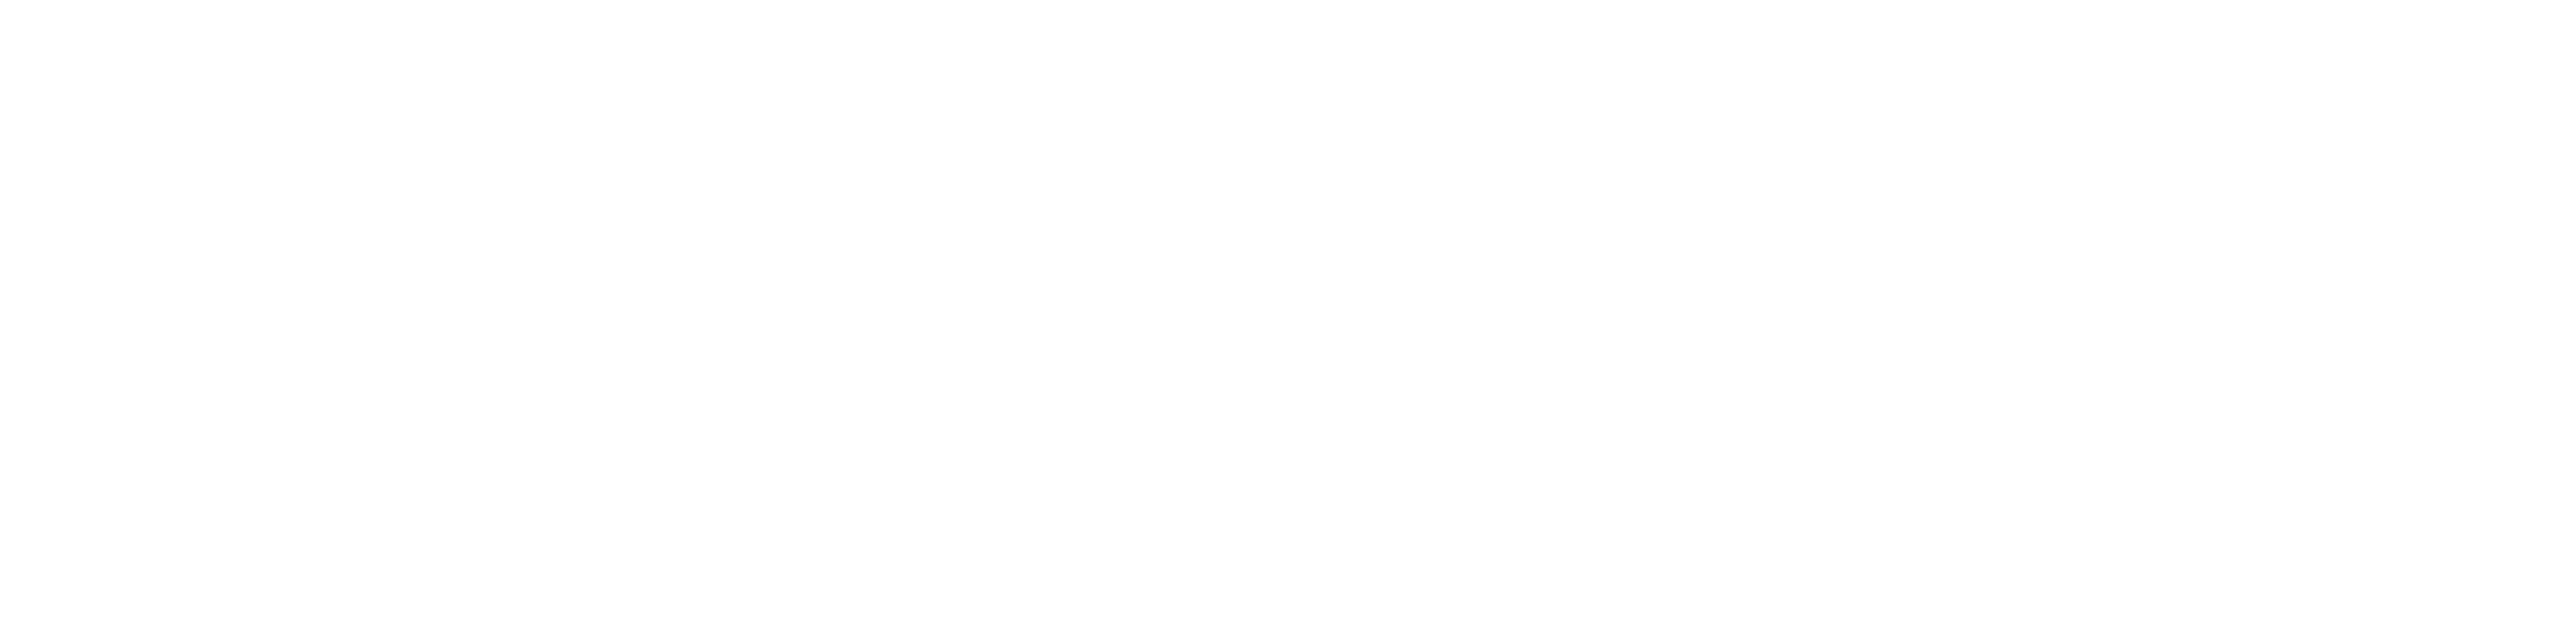

2020-06-16 17:12:34,800 logger INFO Fitting loss 0.232042, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051105, toSparseCloudLoss 0.125153, MemUsed:2228.38
2020-06-16 17:12:34,800 logger INFO Fitting loss 0.232042, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051105, toSparseCloudLoss 0.125153, MemUsed:2228.38
2020-06-16 17:12:34,800 logger INFO Fitting loss 0.232042, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051105, toSparseCloudLoss 0.125153, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


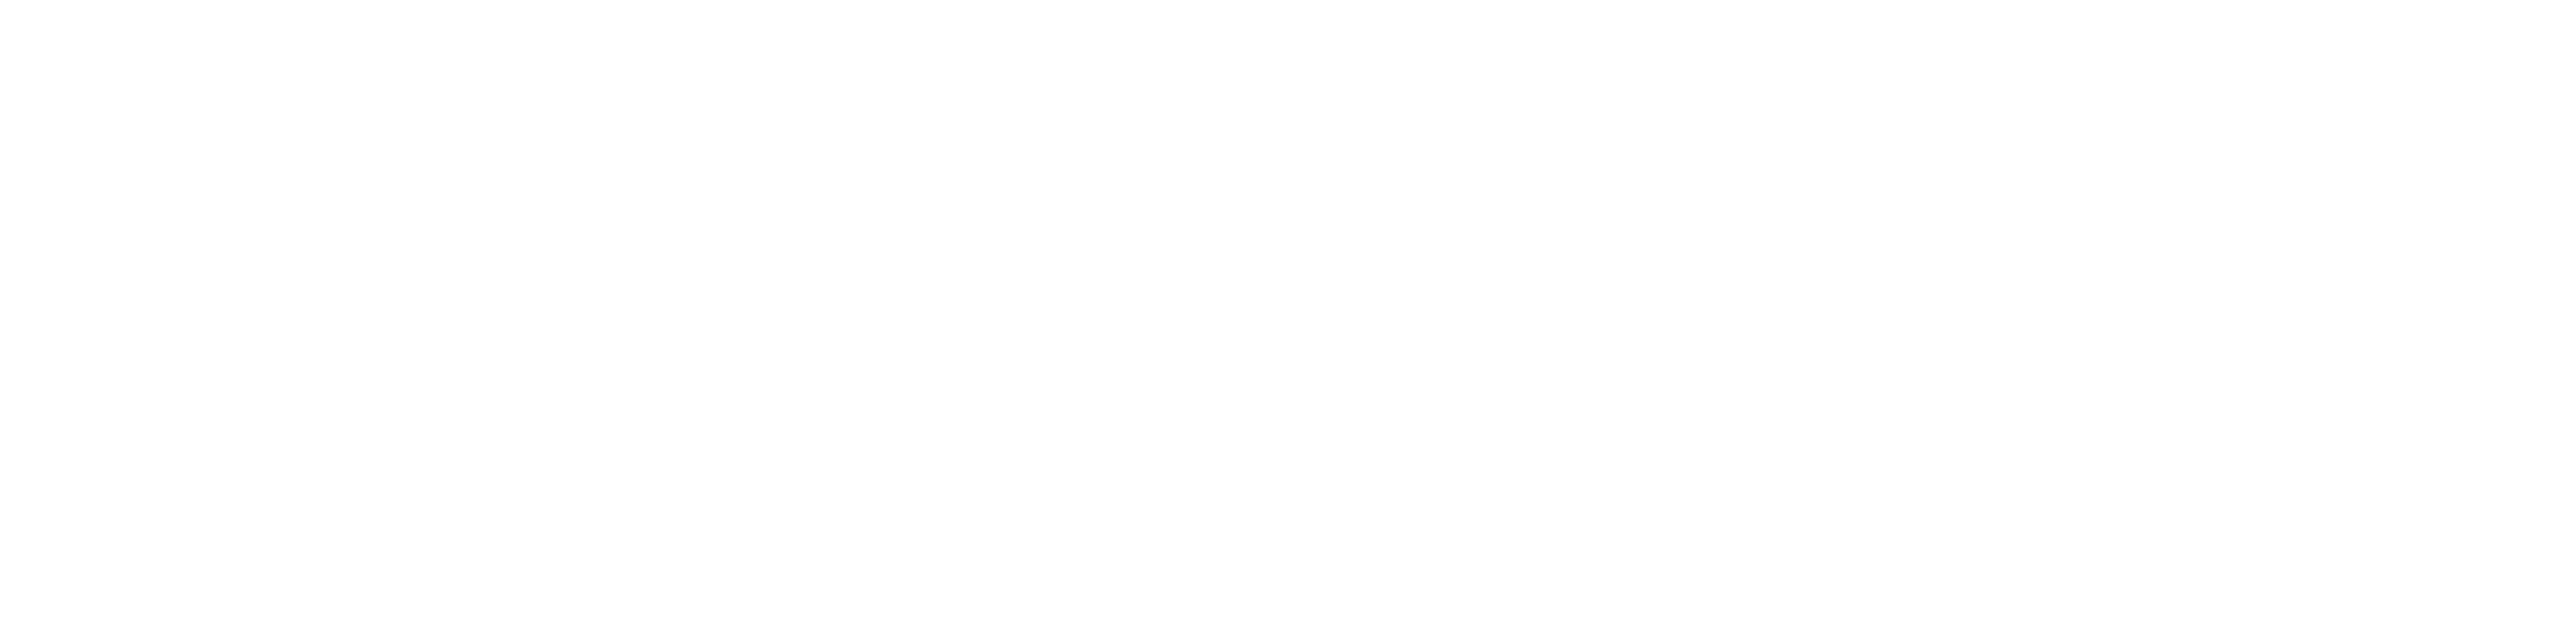

2020-06-16 17:12:57,252 logger INFO Fitting loss 0.228257, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051074, toSparseCloudLoss 0.124096, MemUsed:2228.38
2020-06-16 17:12:57,252 logger INFO Fitting loss 0.228257, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051074, toSparseCloudLoss 0.124096, MemUsed:2228.38
2020-06-16 17:12:57,252 logger INFO Fitting loss 0.228257, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051074, toSparseCloudLoss 0.124096, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


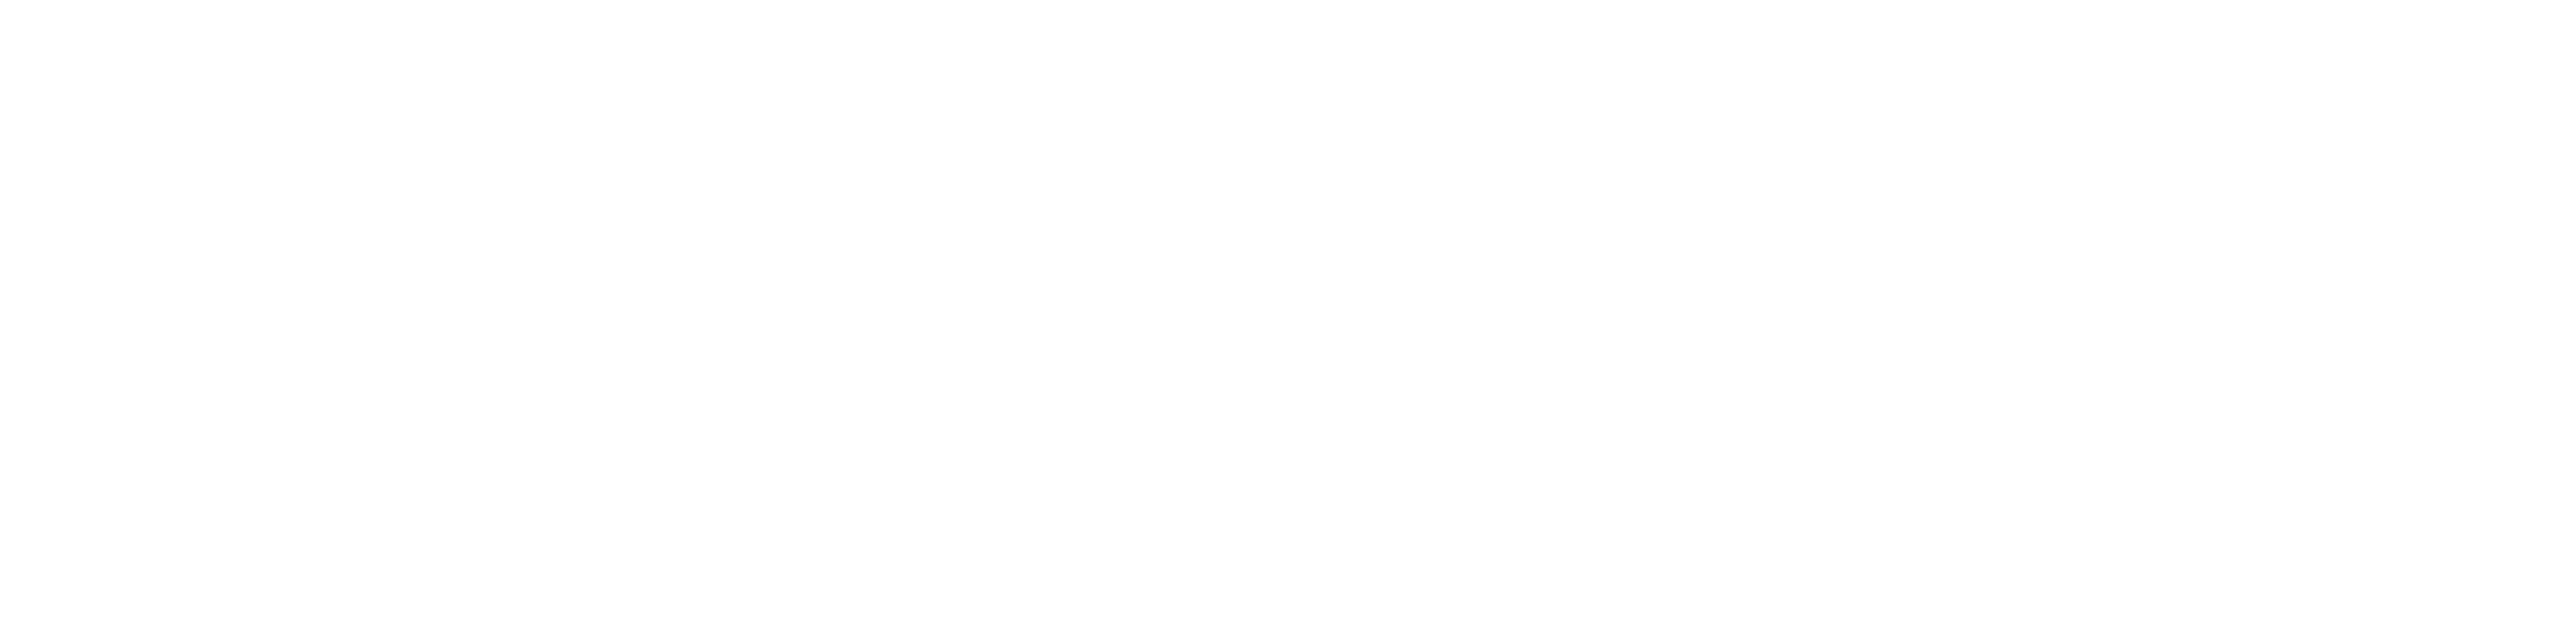

2020-06-16 17:13:19,784 logger INFO Fitting loss 0.225847, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051044, toSparseCloudLoss 0.122820, MemUsed:2228.38
2020-06-16 17:13:19,784 logger INFO Fitting loss 0.225847, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051044, toSparseCloudLoss 0.122820, MemUsed:2228.38
2020-06-16 17:13:19,784 logger INFO Fitting loss 0.225847, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051044, toSparseCloudLoss 0.122820, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


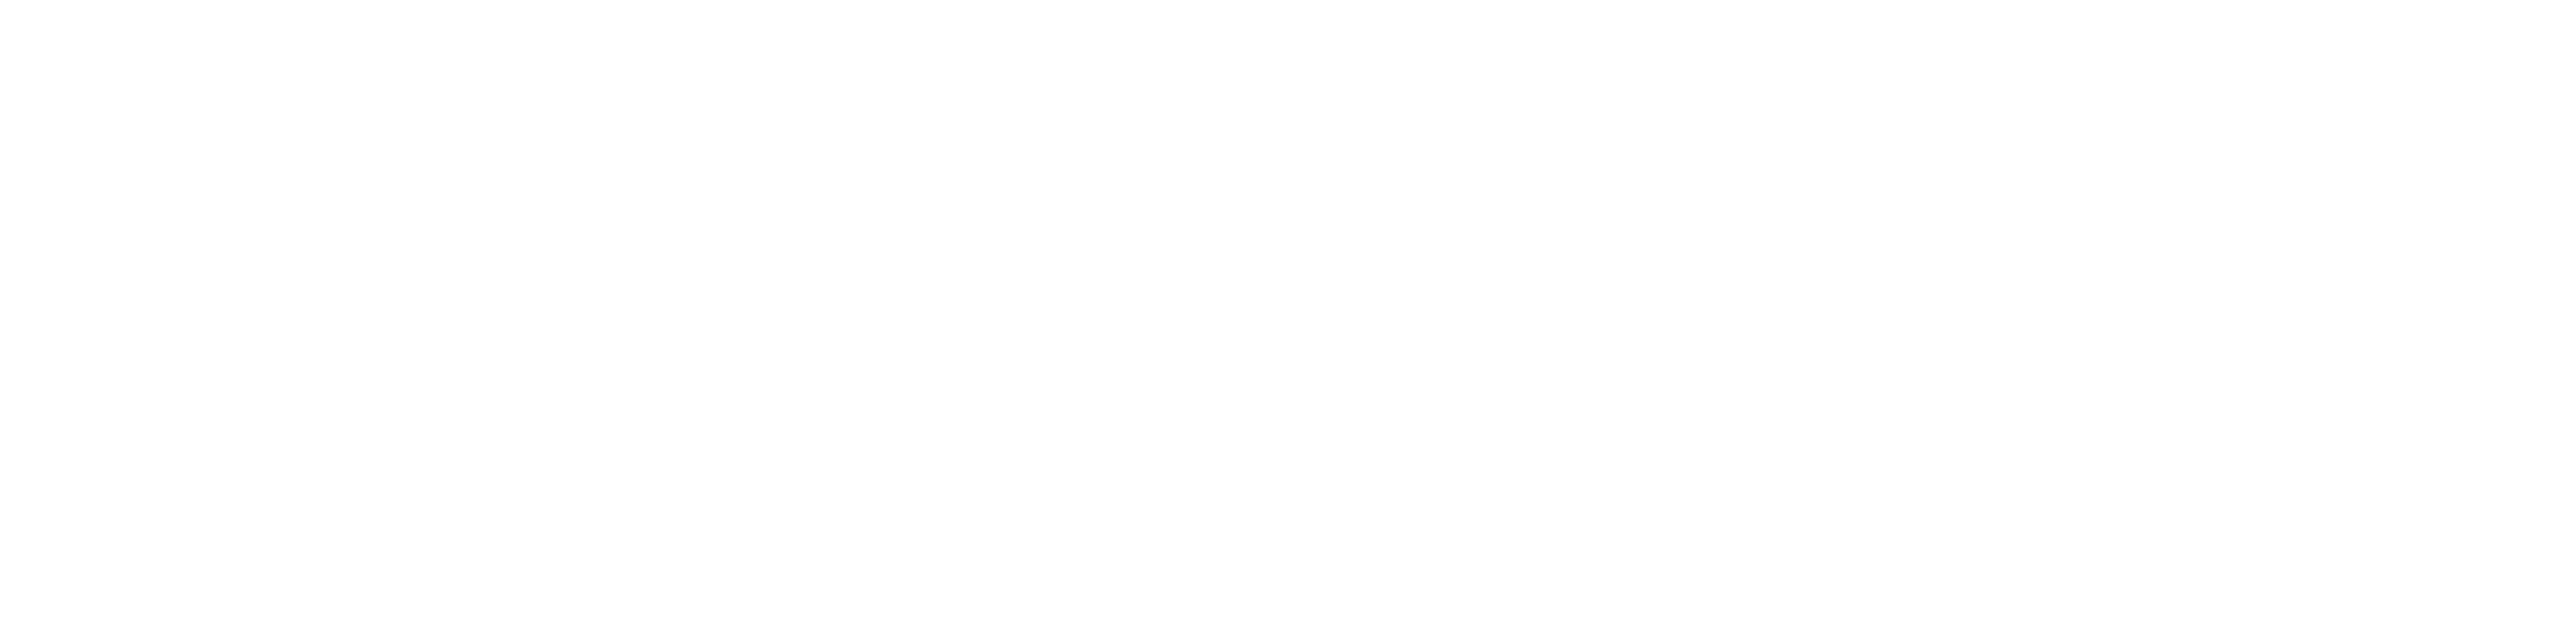

2020-06-16 17:13:42,341 logger INFO Fitting loss 0.226286, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051014, toSparseCloudLoss 0.121766, MemUsed:2228.38
2020-06-16 17:13:42,341 logger INFO Fitting loss 0.226286, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051014, toSparseCloudLoss 0.121766, MemUsed:2228.38
2020-06-16 17:13:42,341 logger INFO Fitting loss 0.226286, normal regularizer loss 0.000000, Laplacian regularizer loss 0.051014, toSparseCloudLoss 0.121766, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


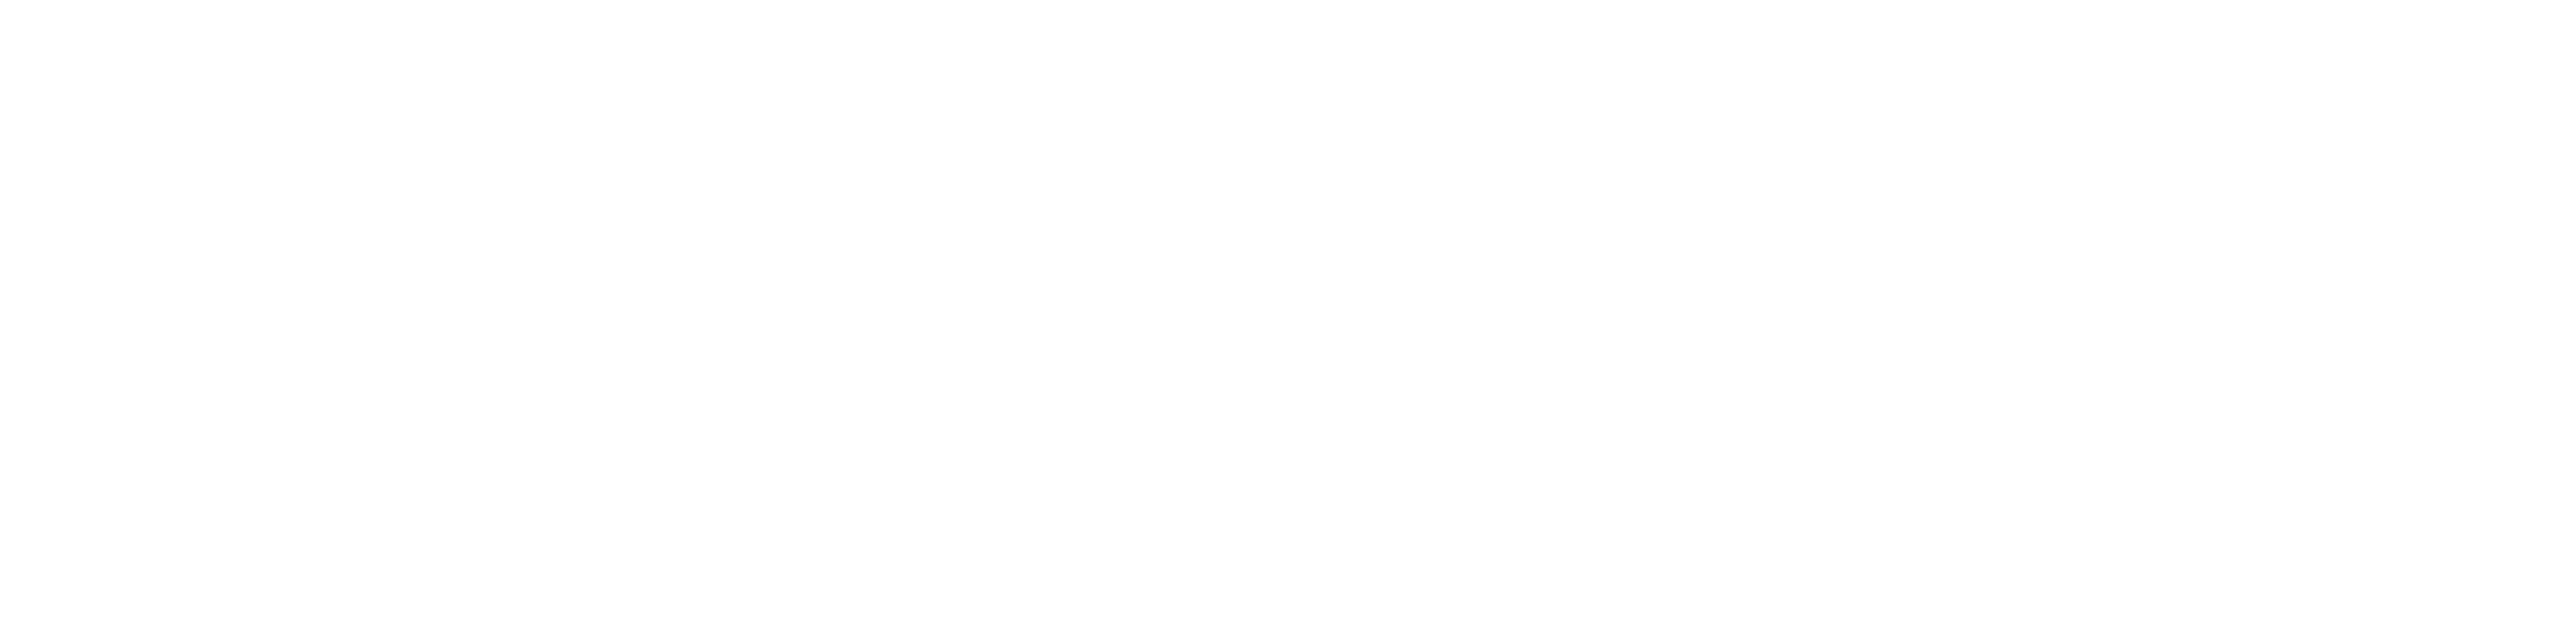

2020-06-16 17:14:04,843 logger INFO Fitting loss 0.226479, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050984, toSparseCloudLoss 0.120775, MemUsed:2228.38
2020-06-16 17:14:04,843 logger INFO Fitting loss 0.226479, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050984, toSparseCloudLoss 0.120775, MemUsed:2228.38
2020-06-16 17:14:04,843 logger INFO Fitting loss 0.226479, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050984, toSparseCloudLoss 0.120775, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


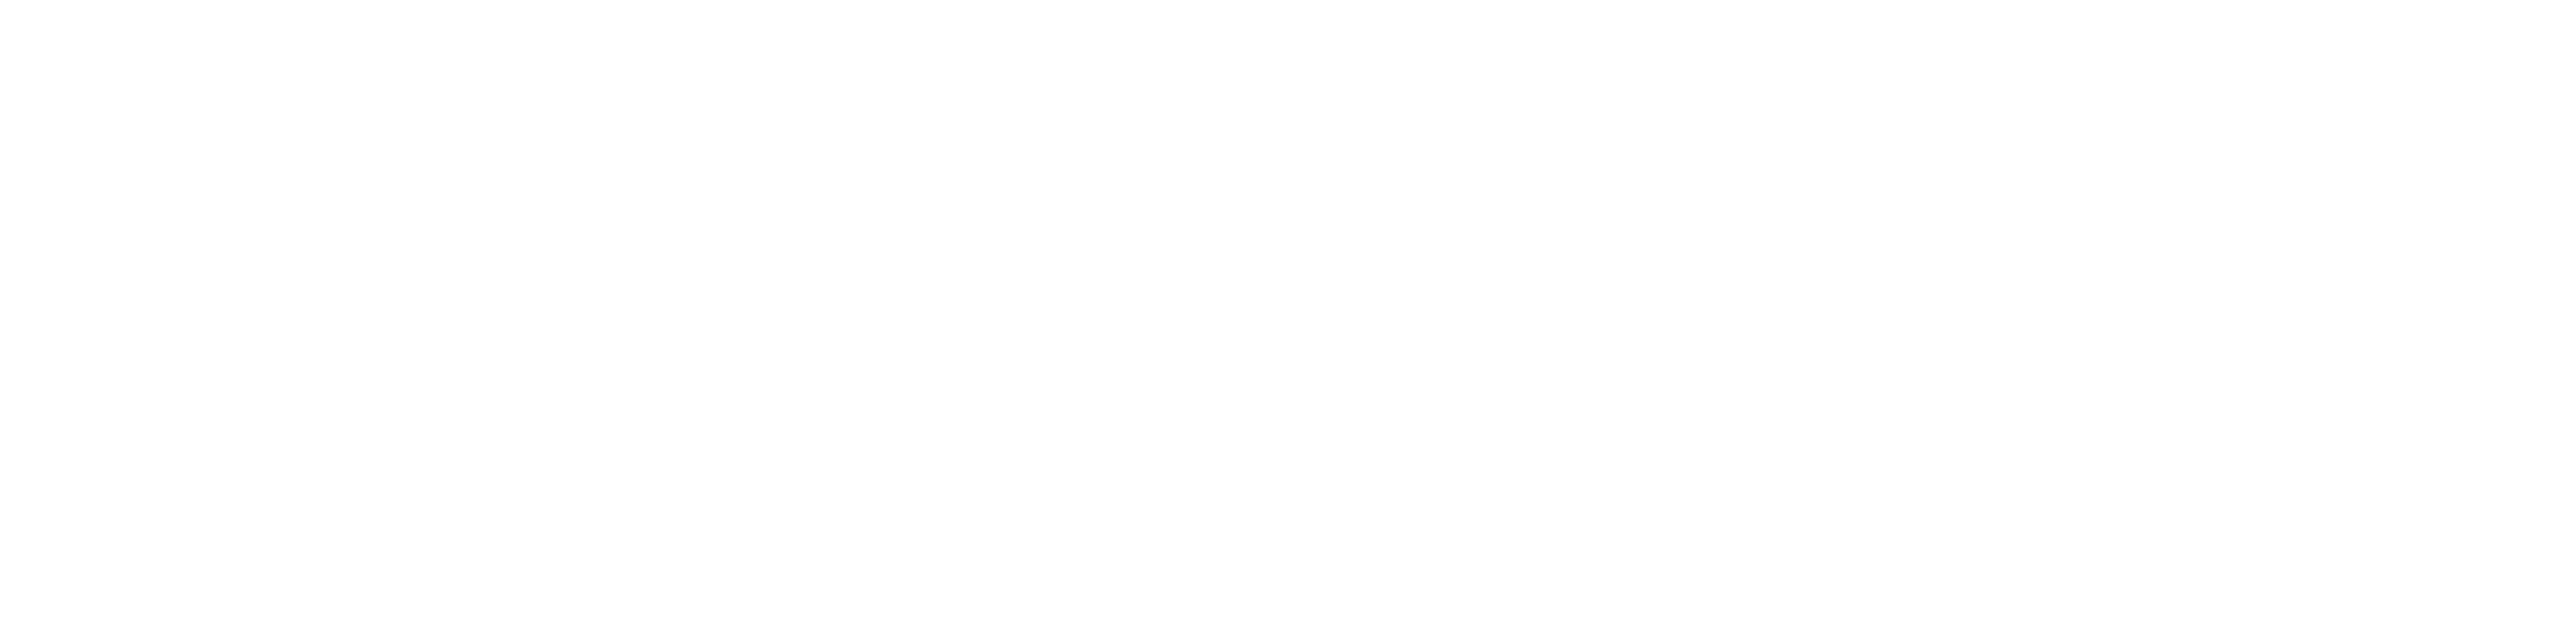

2020-06-16 17:14:27,282 logger INFO Fitting loss 0.224887, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050955, toSparseCloudLoss 0.119776, MemUsed:2228.38
2020-06-16 17:14:27,282 logger INFO Fitting loss 0.224887, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050955, toSparseCloudLoss 0.119776, MemUsed:2228.38
2020-06-16 17:14:27,282 logger INFO Fitting loss 0.224887, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050955, toSparseCloudLoss 0.119776, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


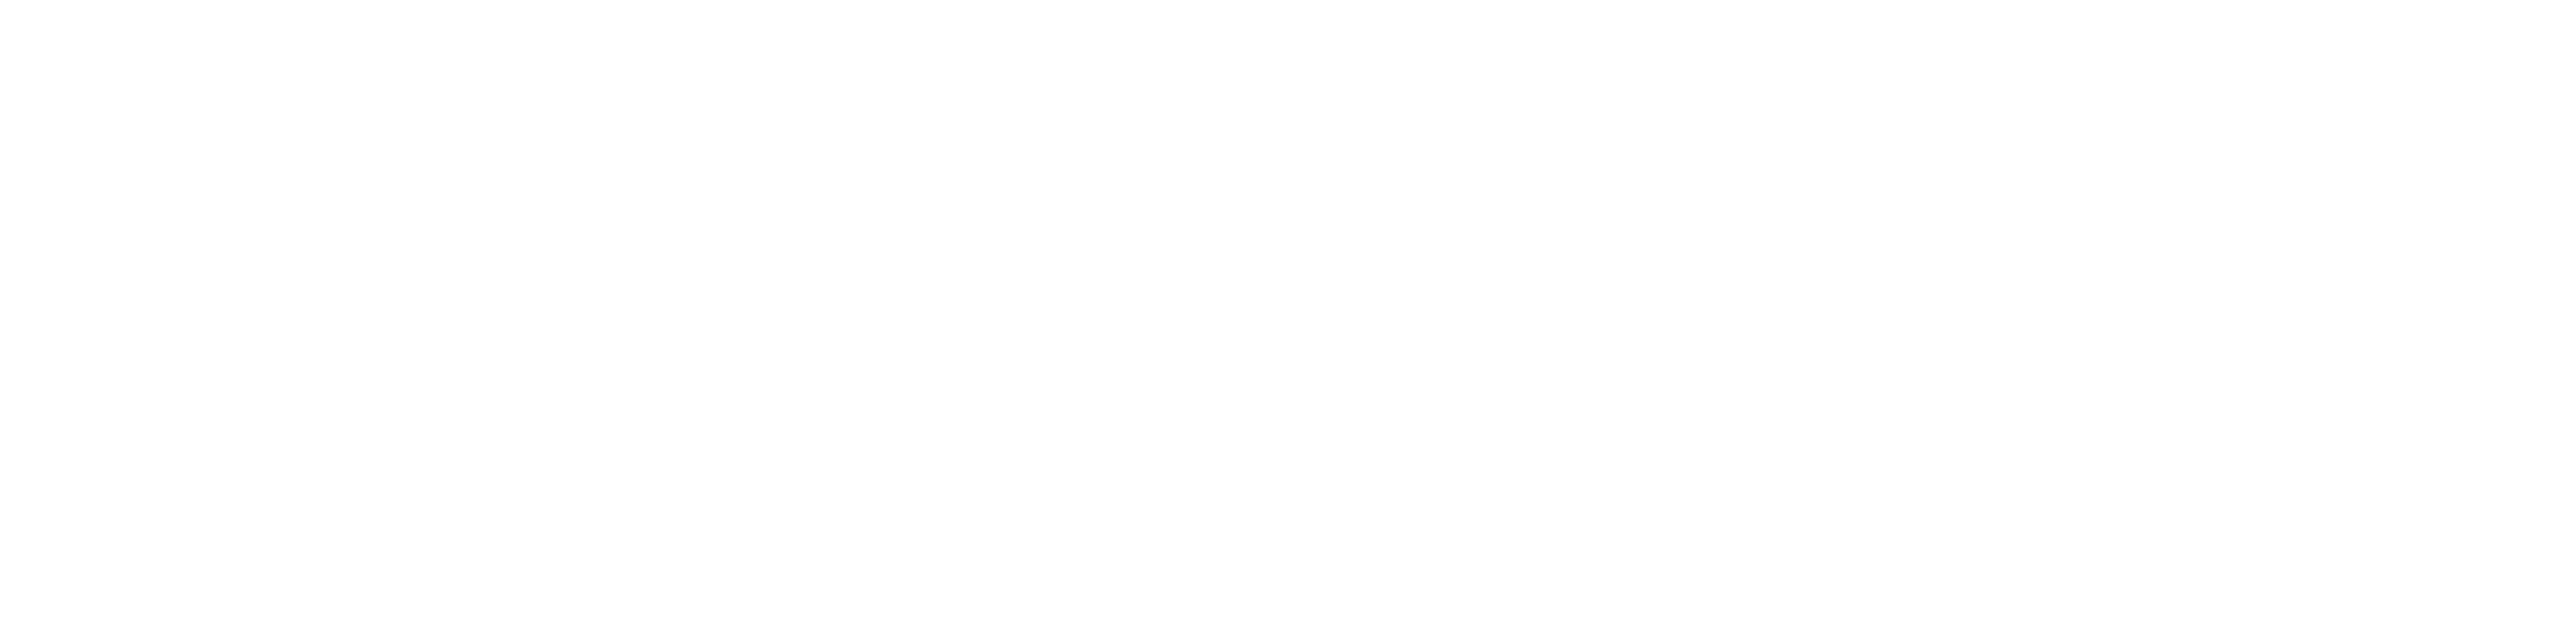

2020-06-16 17:14:49,708 logger INFO Fitting loss 0.222673, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050925, toSparseCloudLoss 0.118886, MemUsed:2228.38
2020-06-16 17:14:49,708 logger INFO Fitting loss 0.222673, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050925, toSparseCloudLoss 0.118886, MemUsed:2228.38
2020-06-16 17:14:49,708 logger INFO Fitting loss 0.222673, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050925, toSparseCloudLoss 0.118886, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


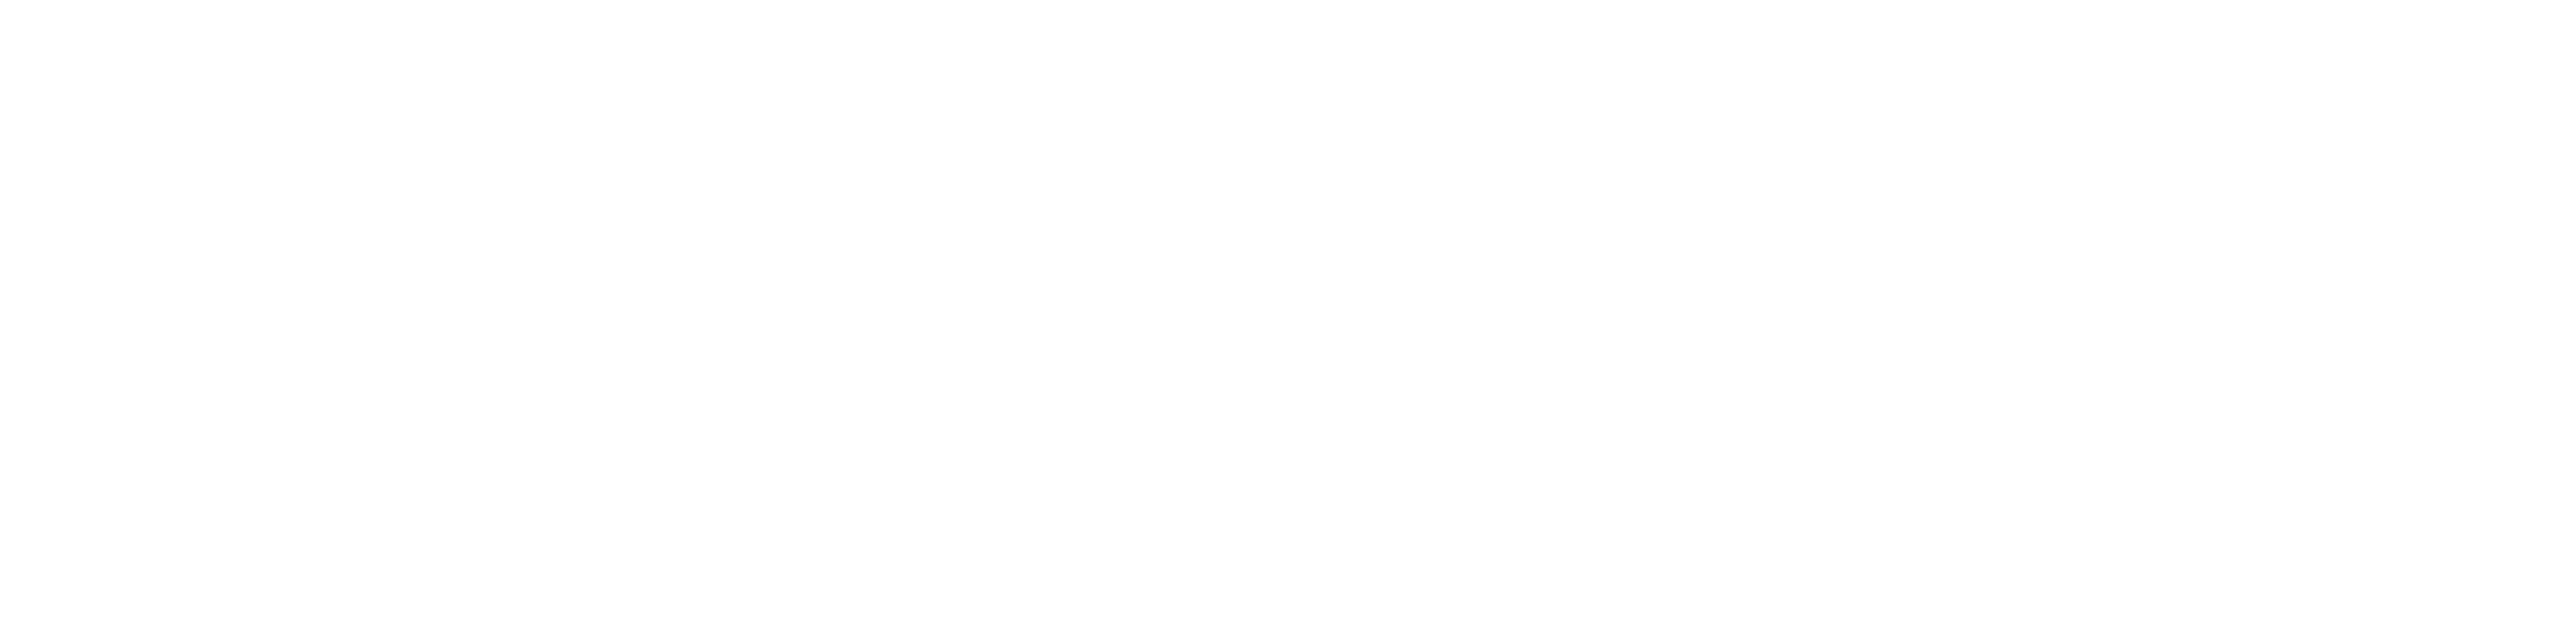

2020-06-16 17:15:12,264 logger INFO Fitting loss 0.221277, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050896, toSparseCloudLoss 0.118113, MemUsed:2228.38
2020-06-16 17:15:12,264 logger INFO Fitting loss 0.221277, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050896, toSparseCloudLoss 0.118113, MemUsed:2228.38
2020-06-16 17:15:12,264 logger INFO Fitting loss 0.221277, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050896, toSparseCloudLoss 0.118113, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


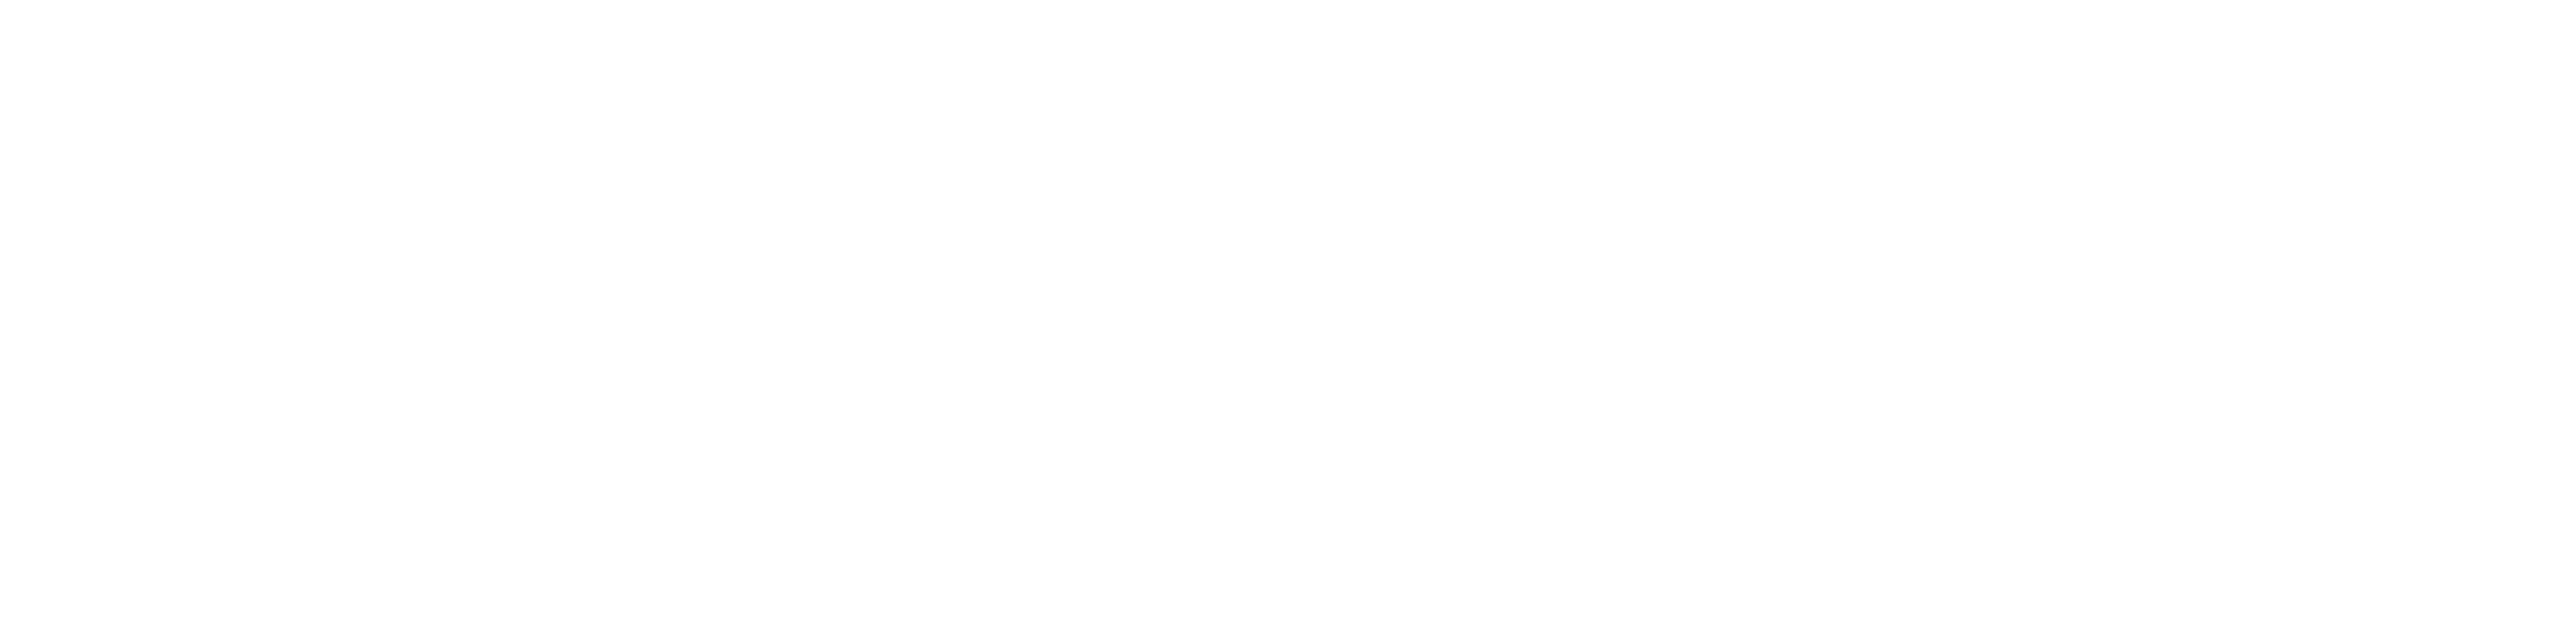

2020-06-16 17:15:34,769 logger INFO Fitting loss 0.220615, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050867, toSparseCloudLoss 0.117236, MemUsed:2228.38
2020-06-16 17:15:34,769 logger INFO Fitting loss 0.220615, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050867, toSparseCloudLoss 0.117236, MemUsed:2228.38
2020-06-16 17:15:34,769 logger INFO Fitting loss 0.220615, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050867, toSparseCloudLoss 0.117236, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


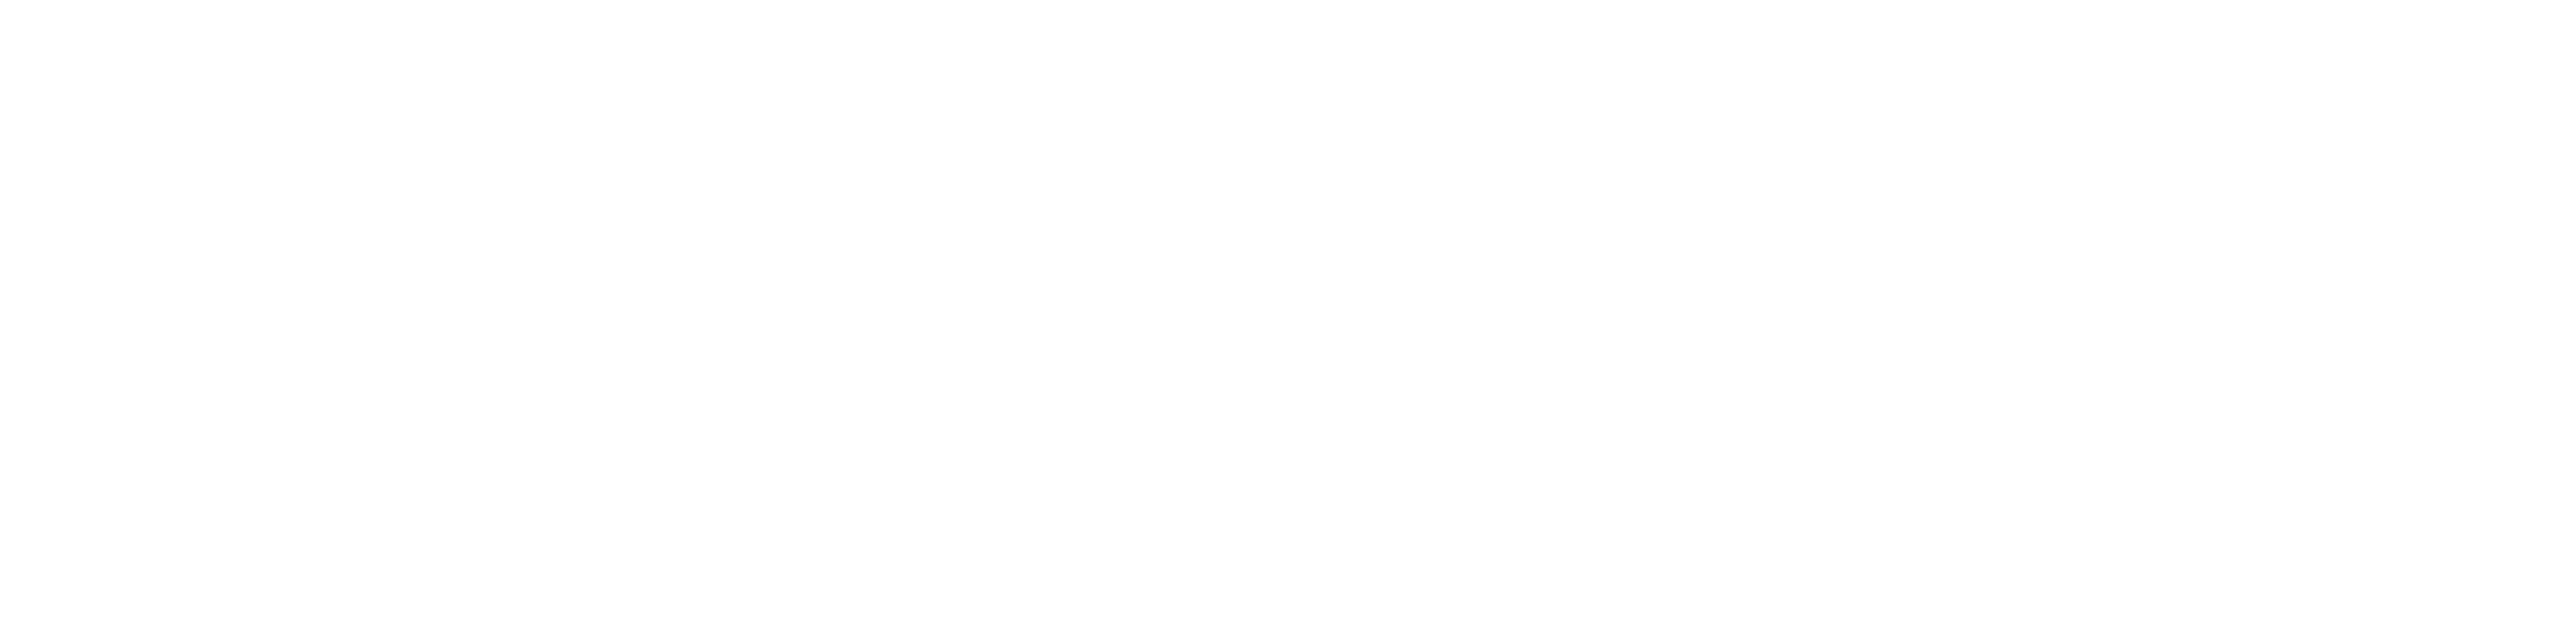

2020-06-16 17:15:57,266 logger INFO Fitting loss 0.219997, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050838, toSparseCloudLoss 0.116202, MemUsed:2228.38
2020-06-16 17:15:57,266 logger INFO Fitting loss 0.219997, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050838, toSparseCloudLoss 0.116202, MemUsed:2228.38
2020-06-16 17:15:57,266 logger INFO Fitting loss 0.219997, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050838, toSparseCloudLoss 0.116202, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


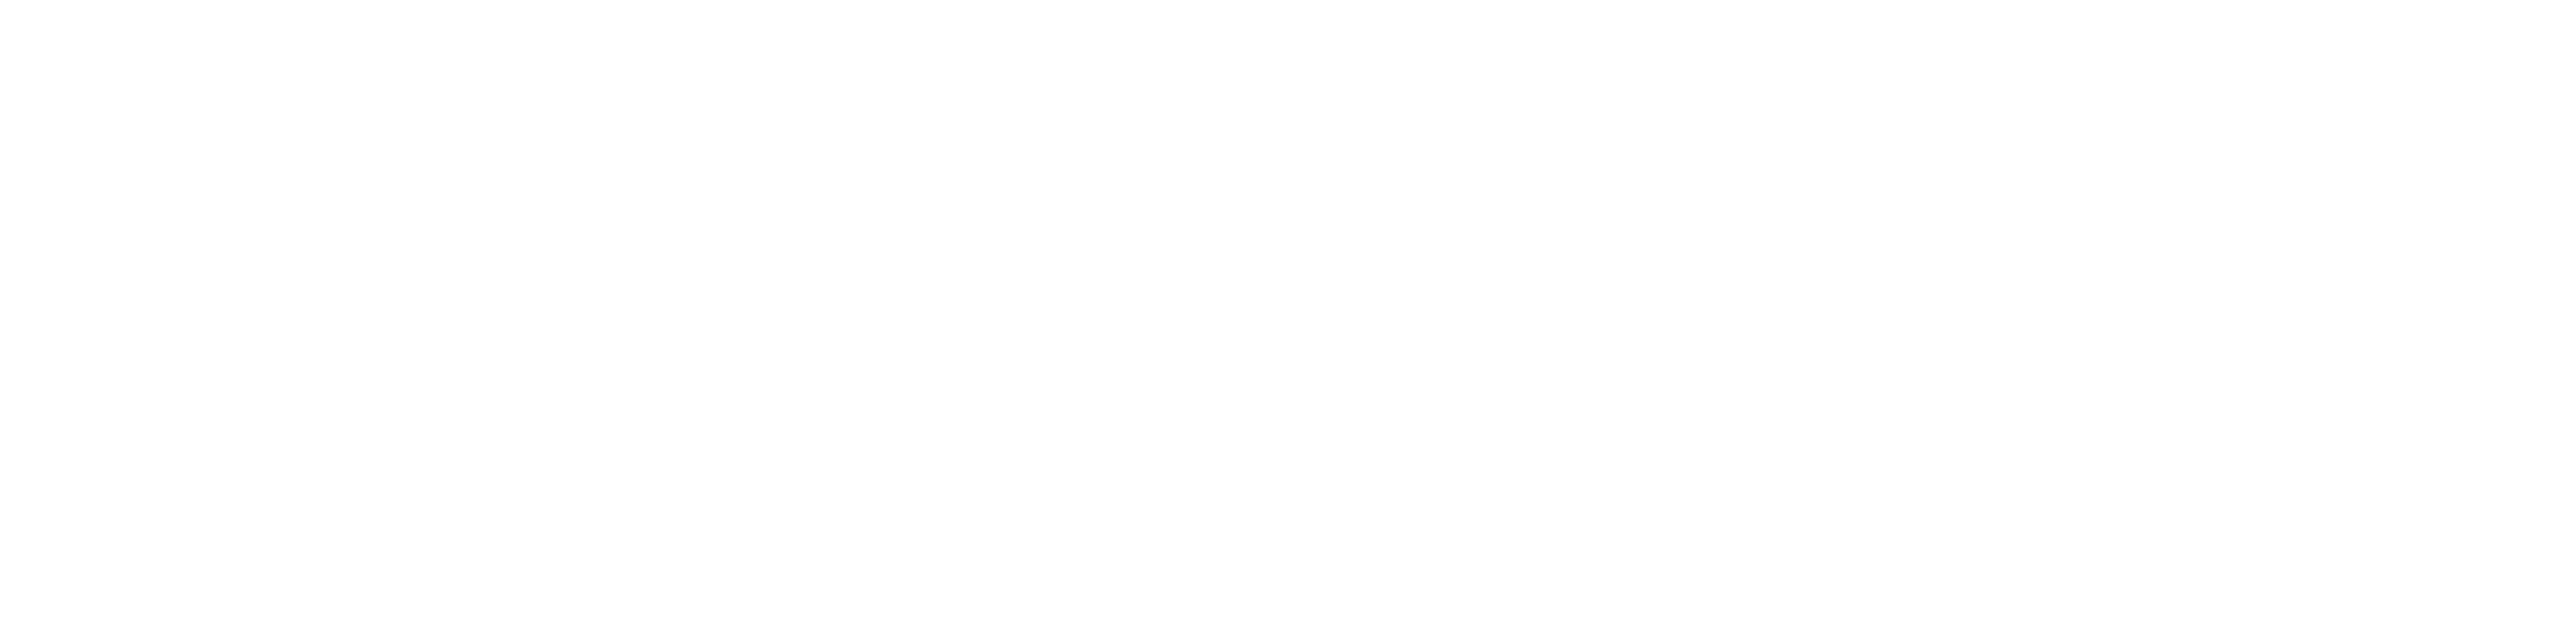

2020-06-16 17:16:19,749 logger INFO Fitting loss 0.219246, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050809, toSparseCloudLoss 0.115169, MemUsed:2228.38
2020-06-16 17:16:19,749 logger INFO Fitting loss 0.219246, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050809, toSparseCloudLoss 0.115169, MemUsed:2228.38
2020-06-16 17:16:19,749 logger INFO Fitting loss 0.219246, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050809, toSparseCloudLoss 0.115169, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


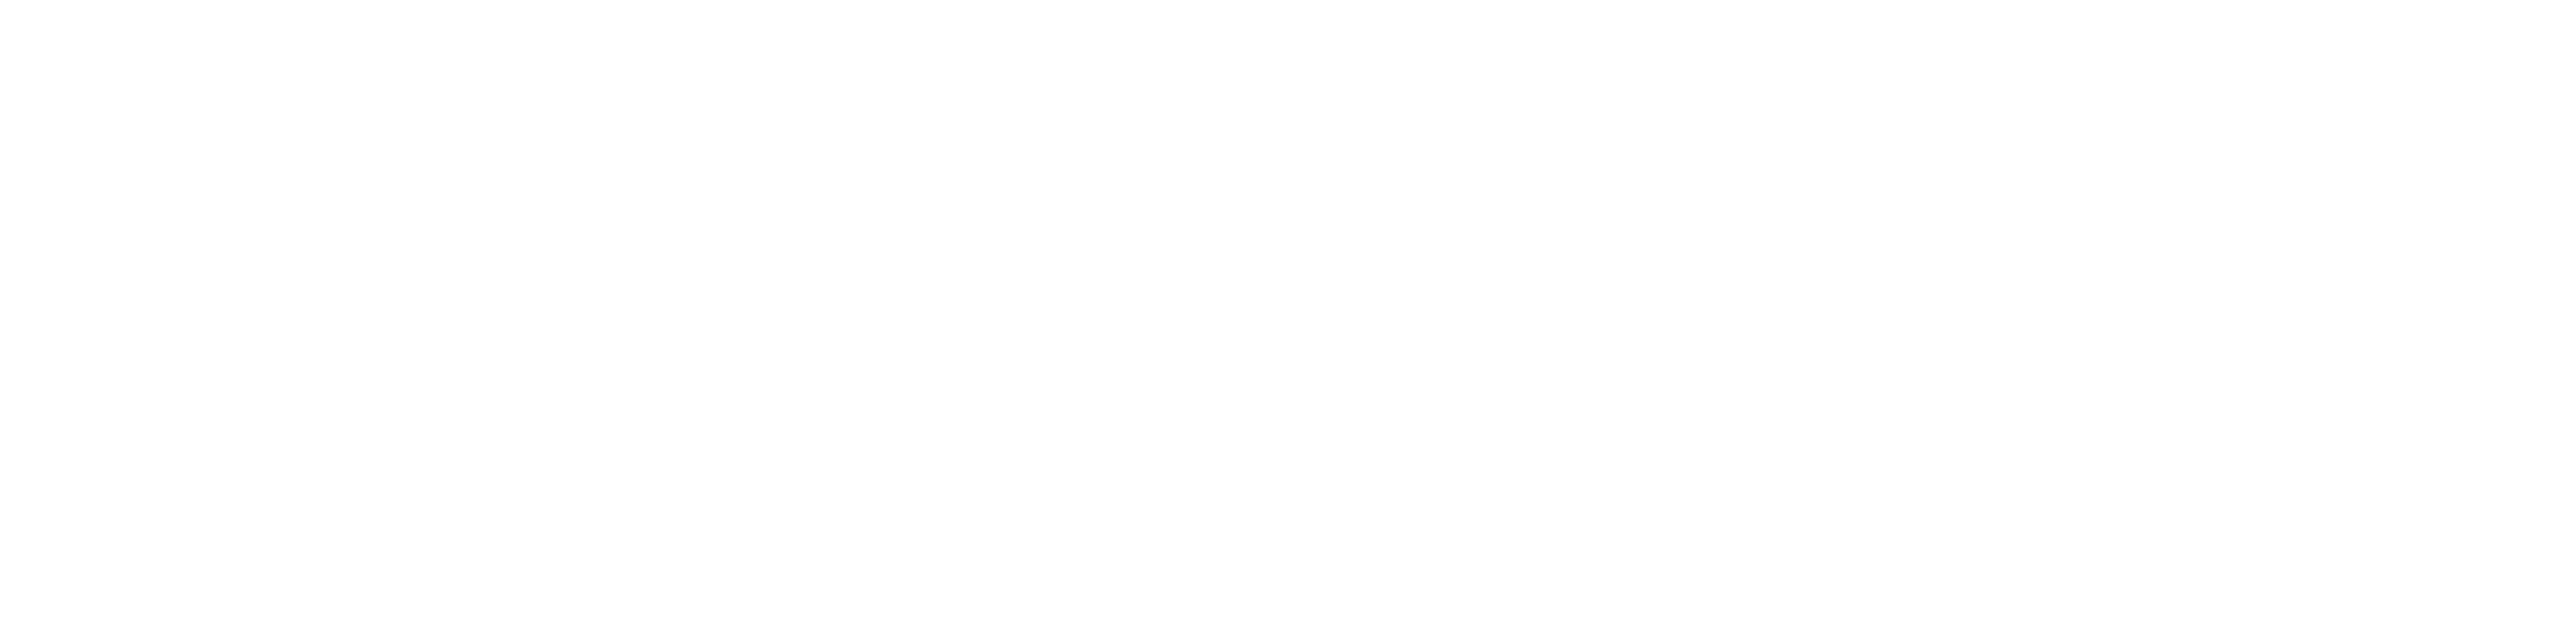

2020-06-16 17:16:42,130 logger INFO Fitting loss 0.218362, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050780, toSparseCloudLoss 0.114271, MemUsed:2228.38
2020-06-16 17:16:42,130 logger INFO Fitting loss 0.218362, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050780, toSparseCloudLoss 0.114271, MemUsed:2228.38
2020-06-16 17:16:42,130 logger INFO Fitting loss 0.218362, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050780, toSparseCloudLoss 0.114271, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


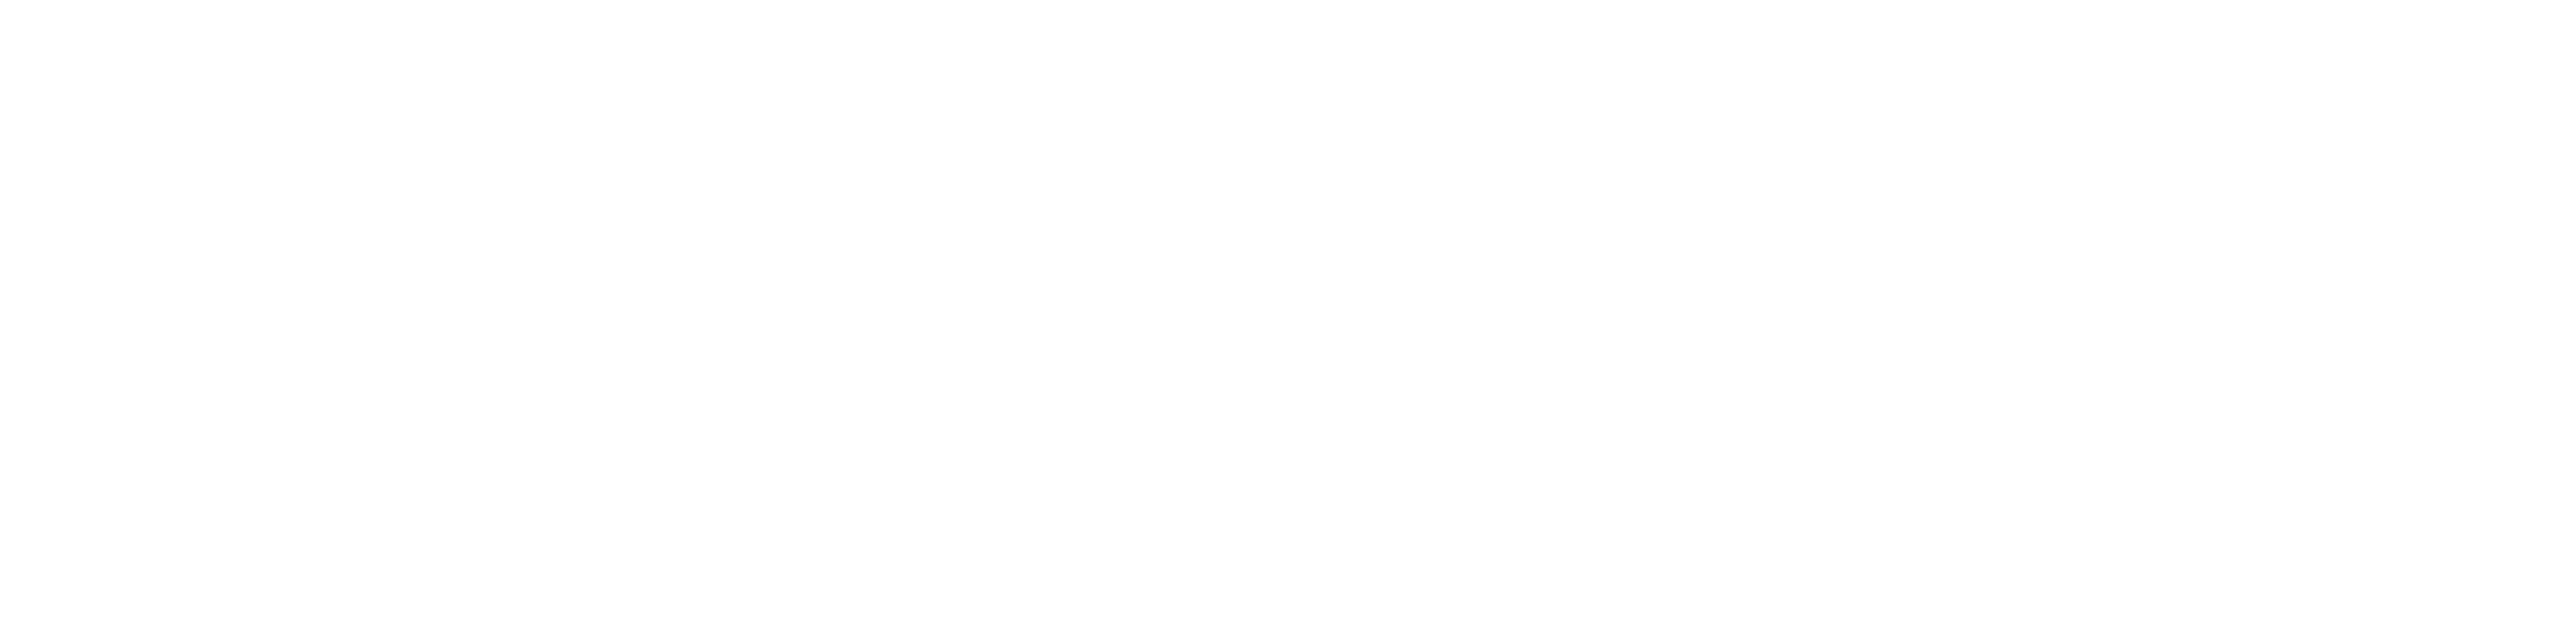

2020-06-16 17:17:04,719 logger INFO Fitting loss 0.217177, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050751, toSparseCloudLoss 0.113454, MemUsed:2228.38
2020-06-16 17:17:04,719 logger INFO Fitting loss 0.217177, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050751, toSparseCloudLoss 0.113454, MemUsed:2228.38
2020-06-16 17:17:04,719 logger INFO Fitting loss 0.217177, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050751, toSparseCloudLoss 0.113454, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


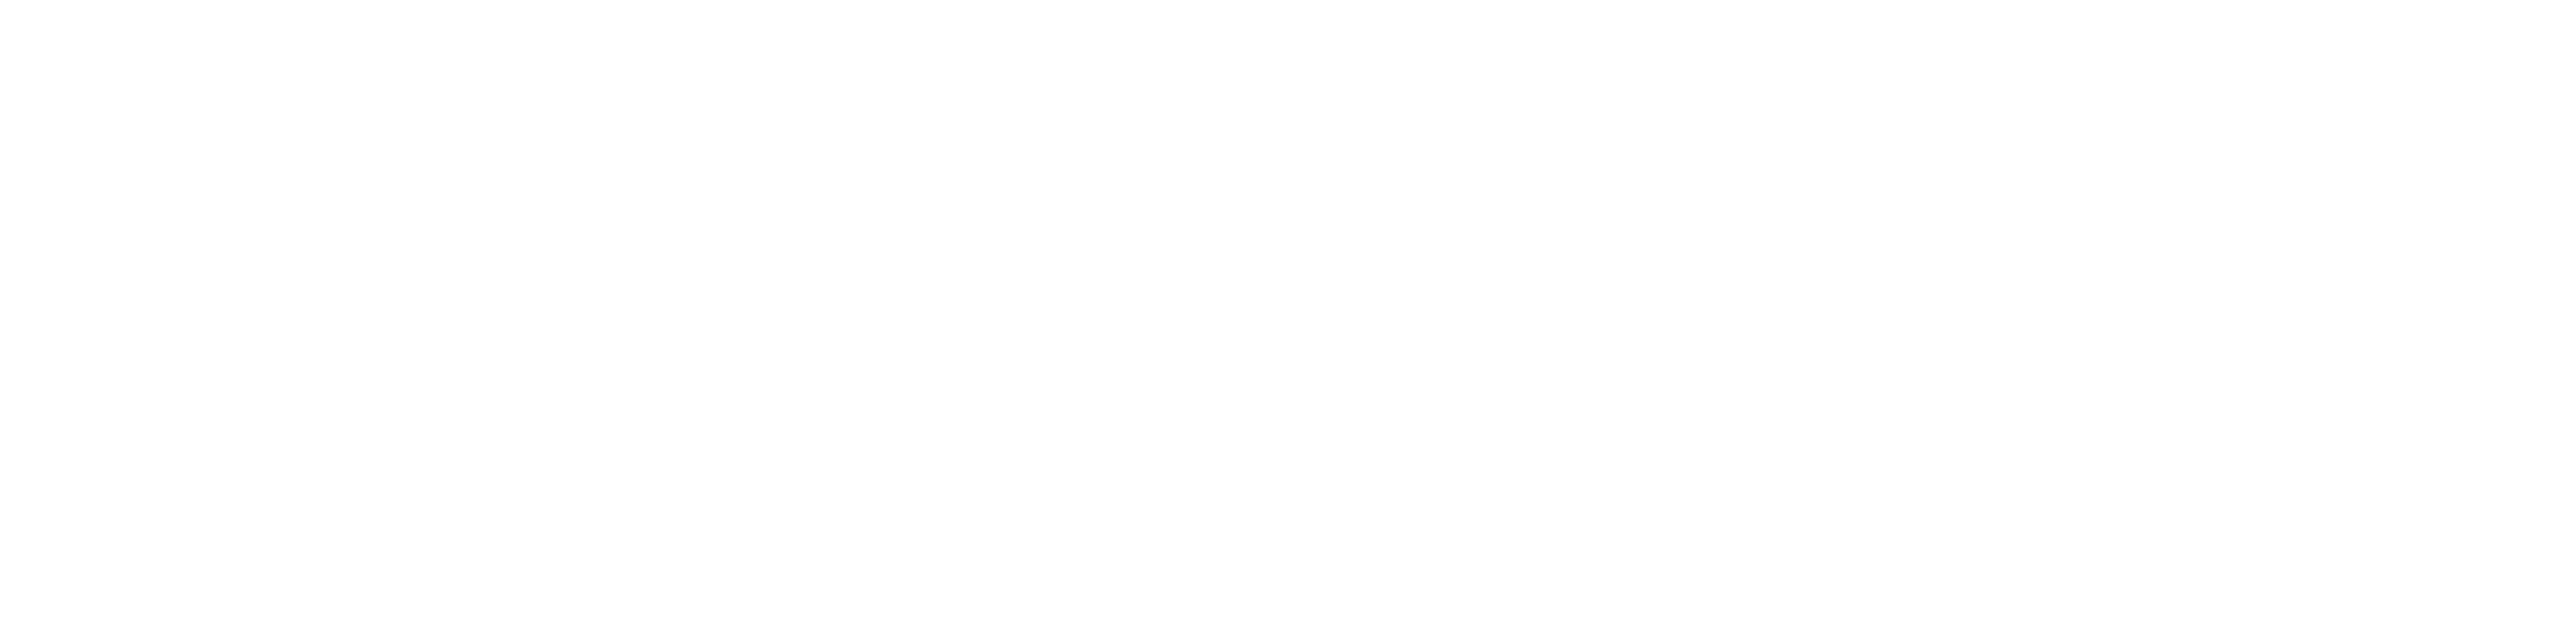

2020-06-16 17:17:27,187 logger INFO Fitting loss 0.215923, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050722, toSparseCloudLoss 0.112669, MemUsed:2228.38
2020-06-16 17:17:27,187 logger INFO Fitting loss 0.215923, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050722, toSparseCloudLoss 0.112669, MemUsed:2228.38
2020-06-16 17:17:27,187 logger INFO Fitting loss 0.215923, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050722, toSparseCloudLoss 0.112669, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


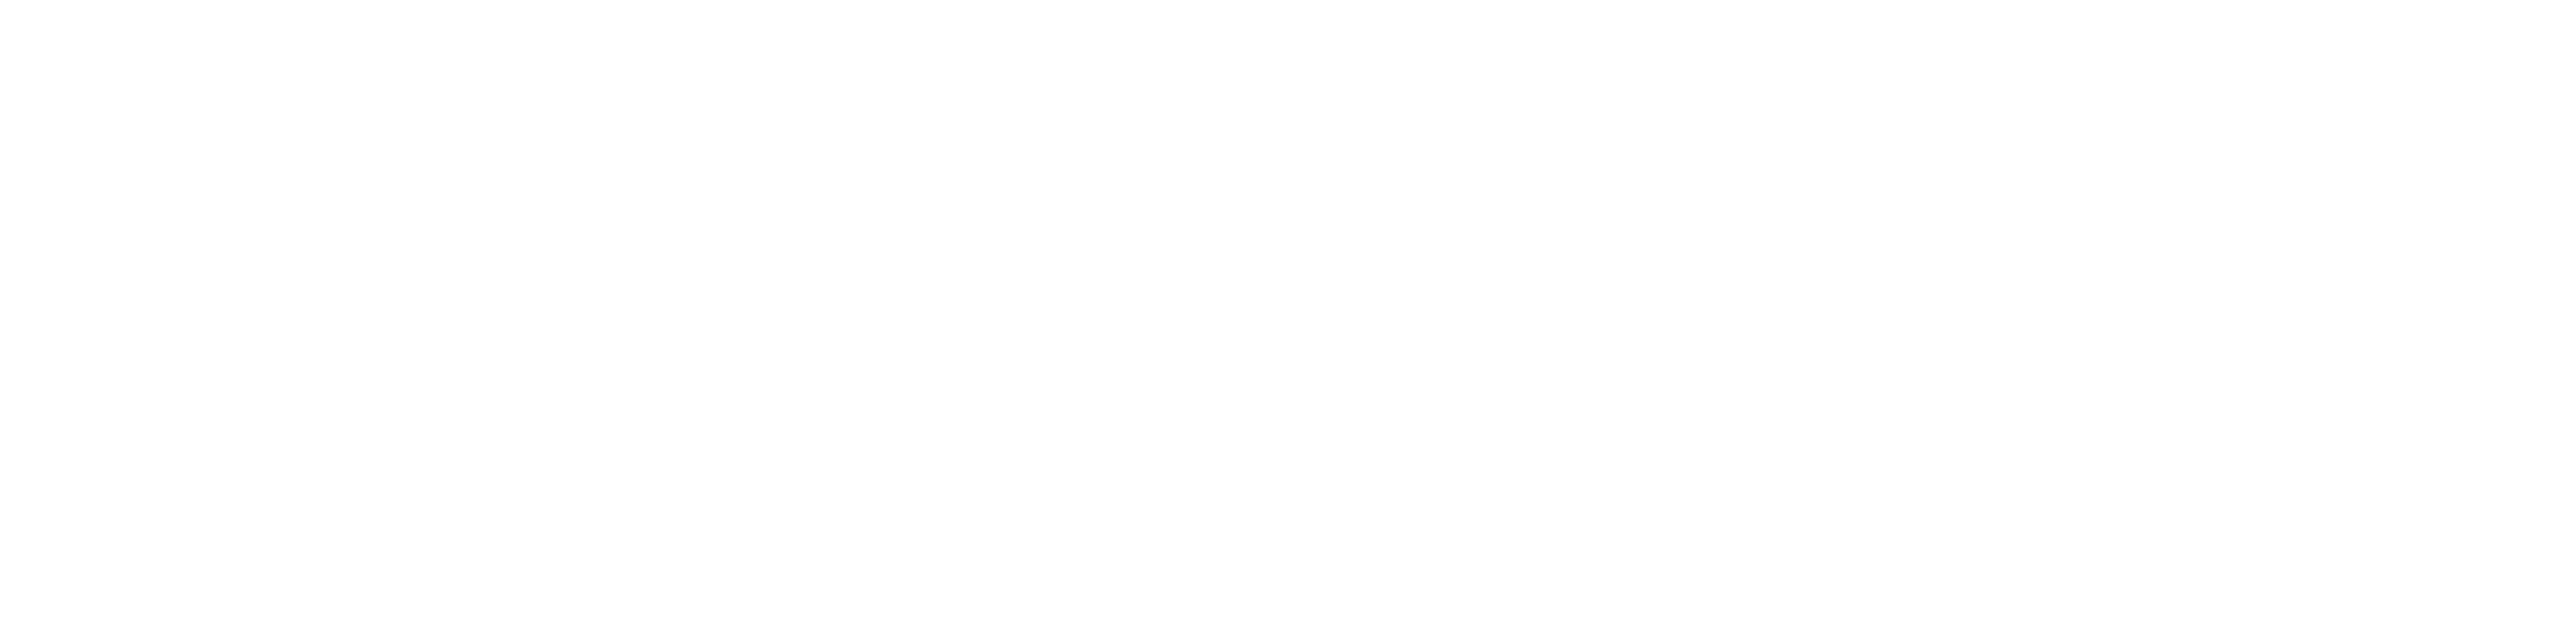

2020-06-16 17:17:49,677 logger INFO Fitting loss 0.215101, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050693, toSparseCloudLoss 0.111939, MemUsed:2228.38
2020-06-16 17:17:49,677 logger INFO Fitting loss 0.215101, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050693, toSparseCloudLoss 0.111939, MemUsed:2228.38
2020-06-16 17:17:49,677 logger INFO Fitting loss 0.215101, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050693, toSparseCloudLoss 0.111939, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


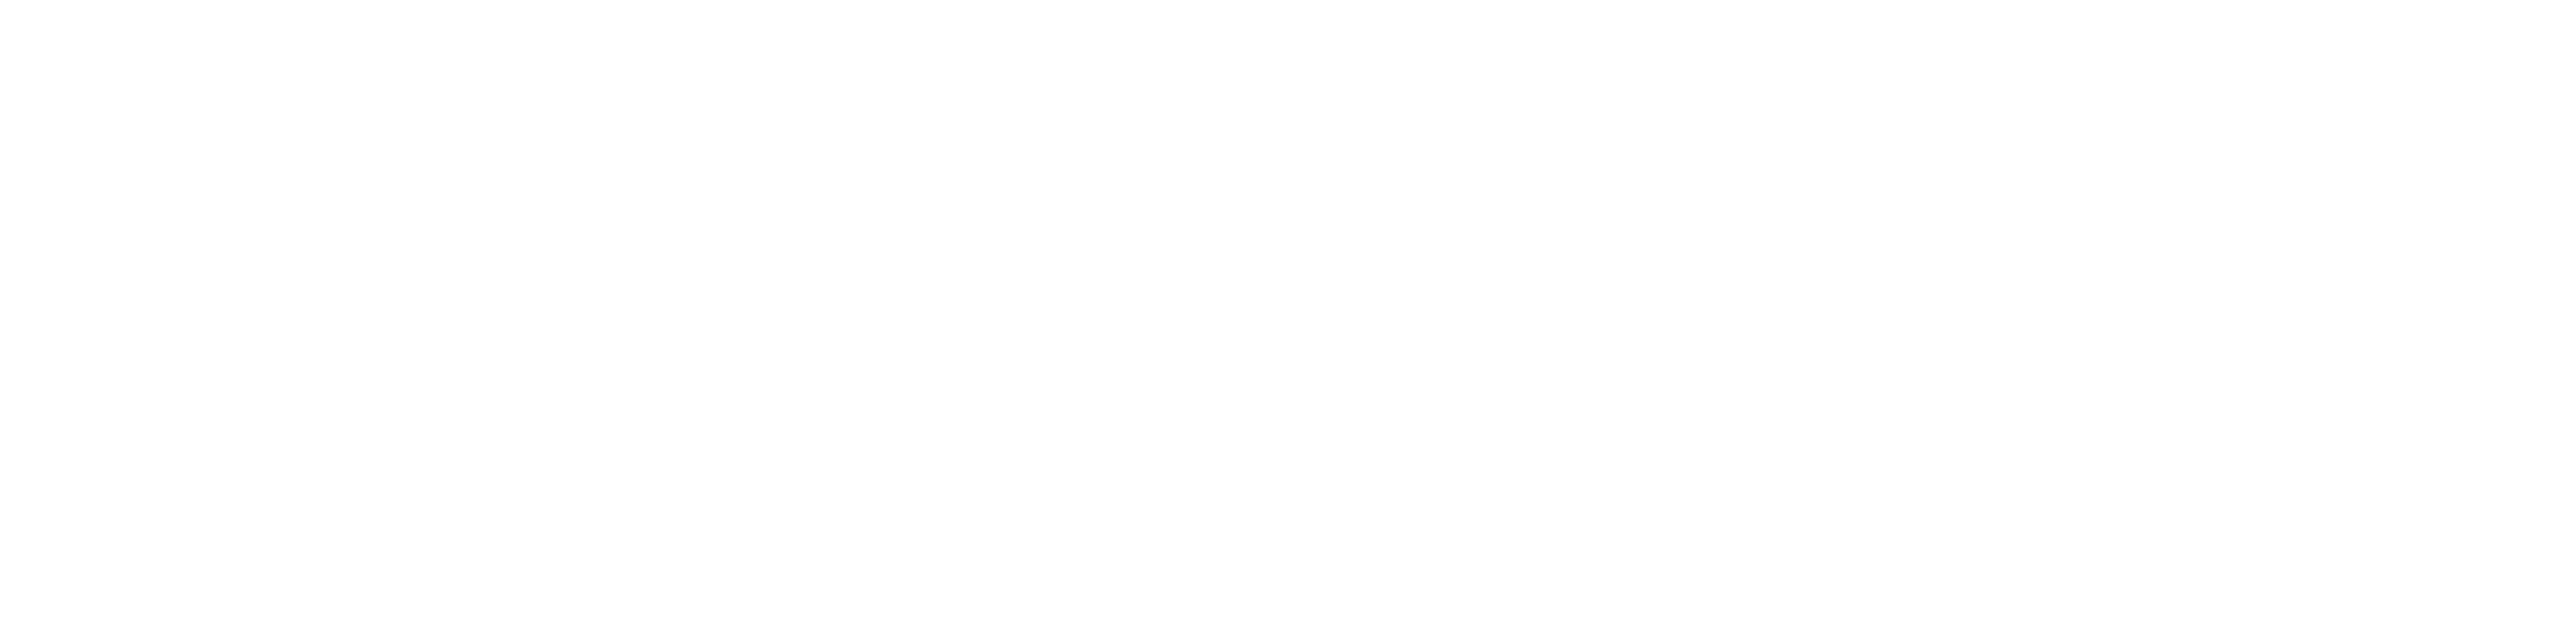

2020-06-16 17:18:12,161 logger INFO Fitting loss 0.214737, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050664, toSparseCloudLoss 0.111272, MemUsed:2228.38
2020-06-16 17:18:12,161 logger INFO Fitting loss 0.214737, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050664, toSparseCloudLoss 0.111272, MemUsed:2228.38
2020-06-16 17:18:12,161 logger INFO Fitting loss 0.214737, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050664, toSparseCloudLoss 0.111272, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


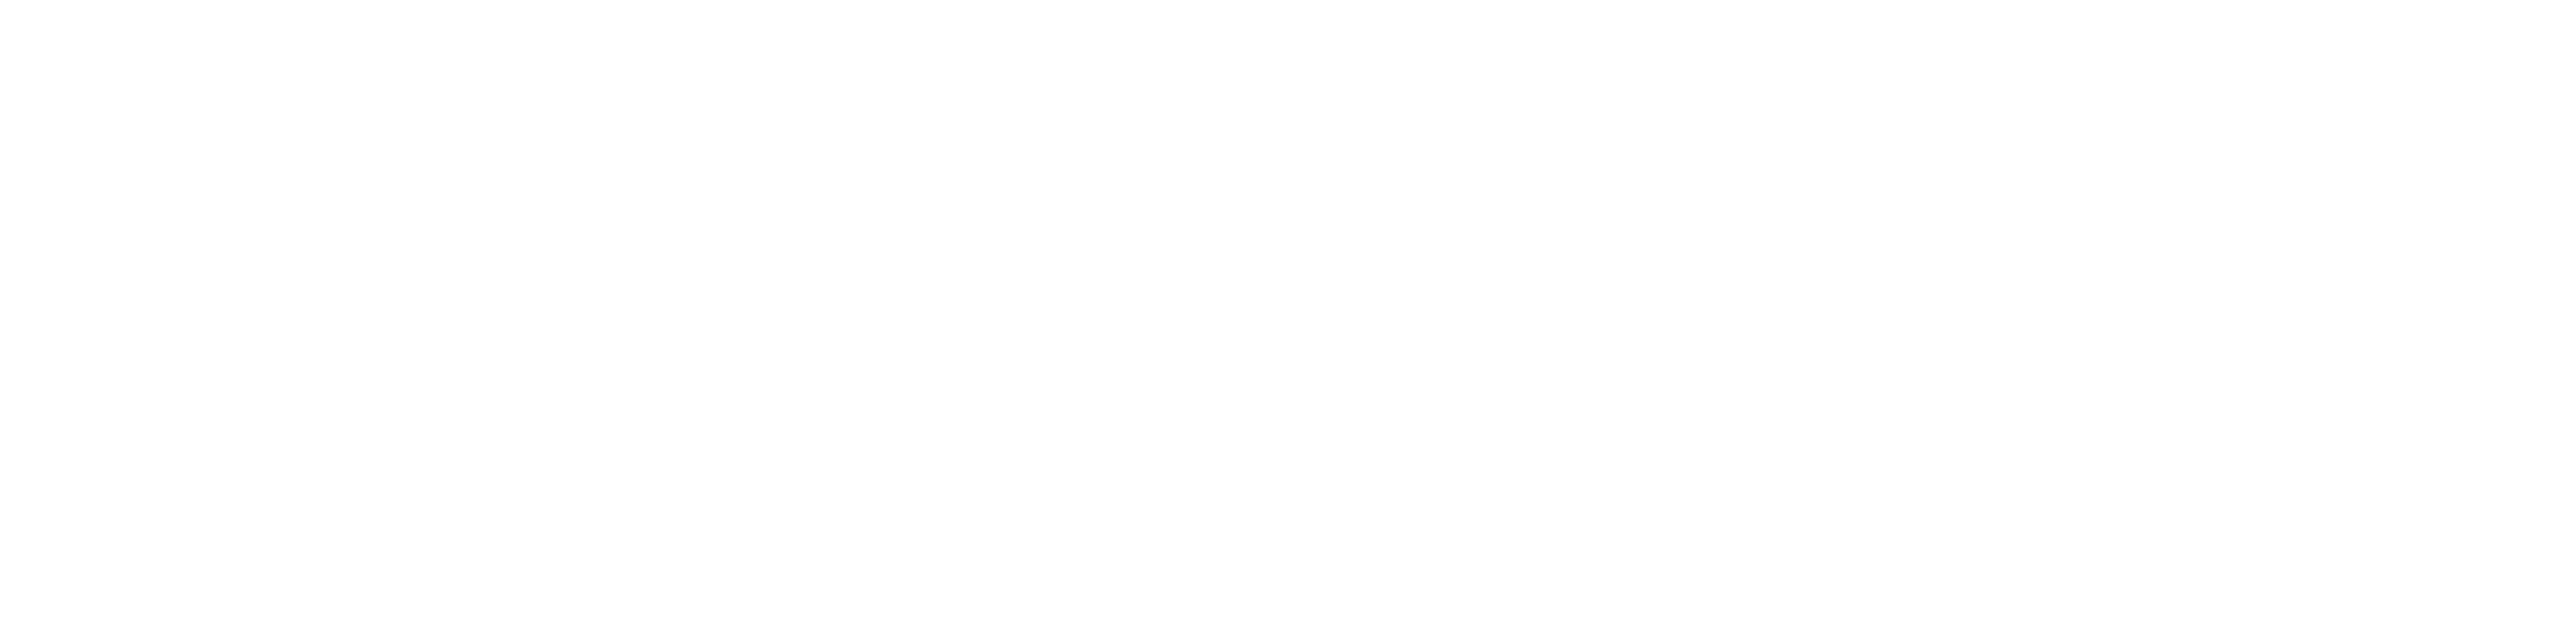

2020-06-16 17:18:34,553 logger INFO Fitting loss 0.214165, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050635, toSparseCloudLoss 0.110581, MemUsed:2228.38
2020-06-16 17:18:34,553 logger INFO Fitting loss 0.214165, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050635, toSparseCloudLoss 0.110581, MemUsed:2228.38
2020-06-16 17:18:34,553 logger INFO Fitting loss 0.214165, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050635, toSparseCloudLoss 0.110581, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


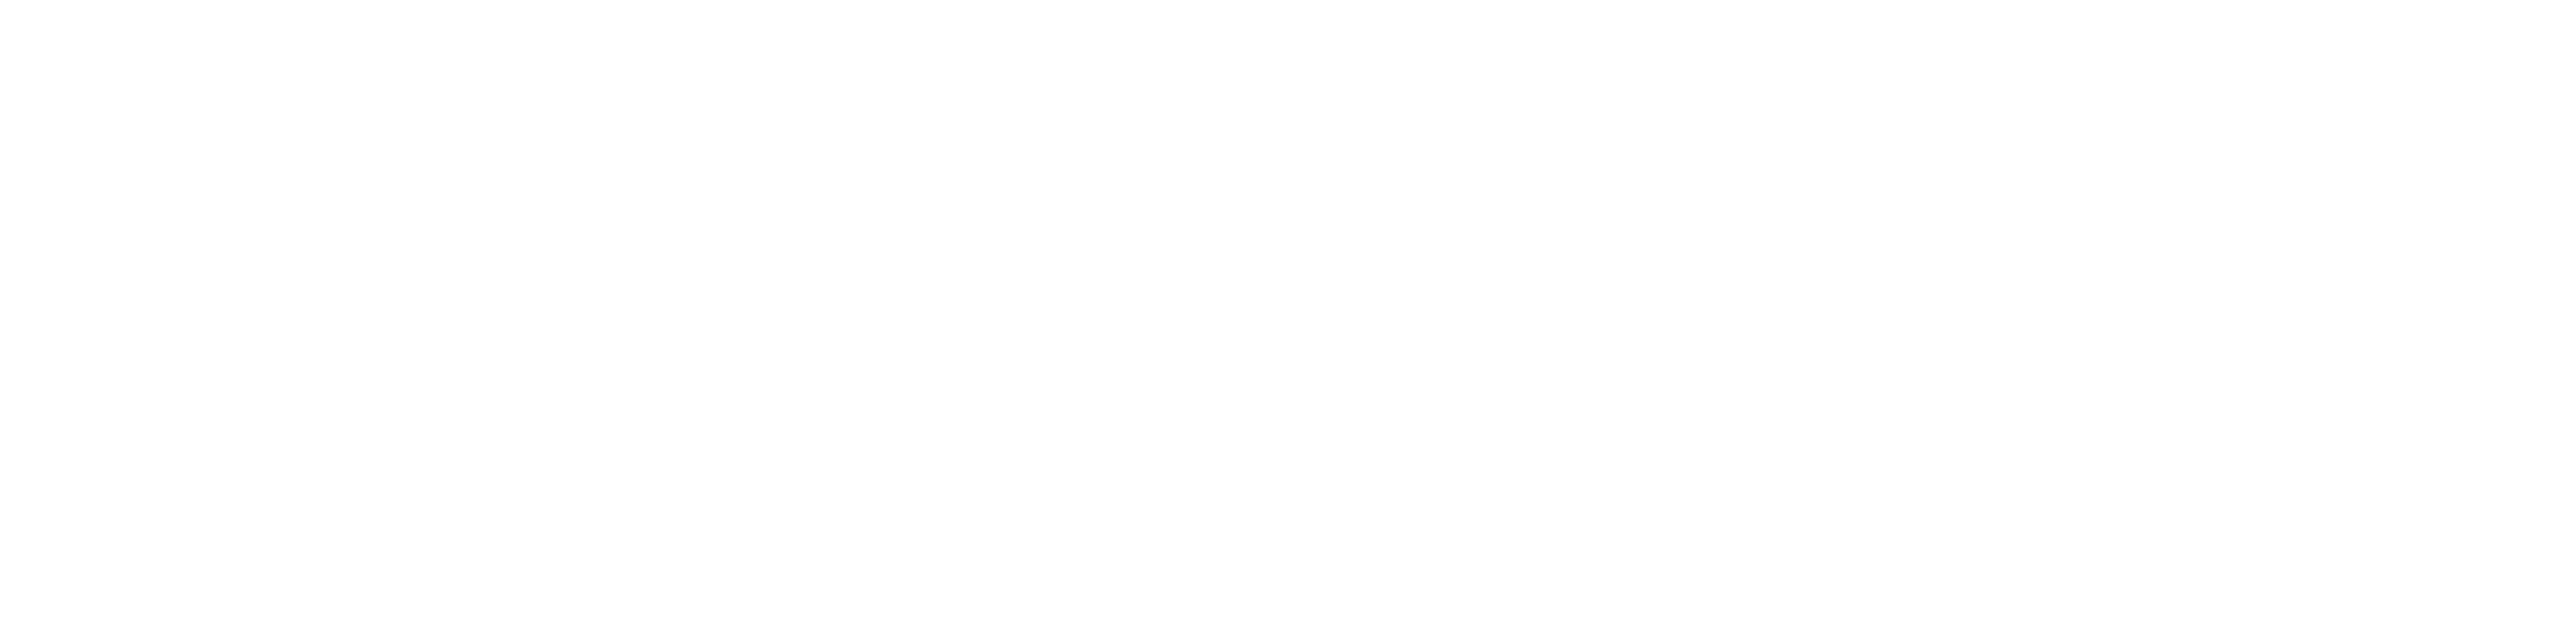

2020-06-16 17:18:57,112 logger INFO Fitting loss 0.213234, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050607, toSparseCloudLoss 0.109815, MemUsed:2228.38
2020-06-16 17:18:57,112 logger INFO Fitting loss 0.213234, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050607, toSparseCloudLoss 0.109815, MemUsed:2228.38
2020-06-16 17:18:57,112 logger INFO Fitting loss 0.213234, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050607, toSparseCloudLoss 0.109815, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


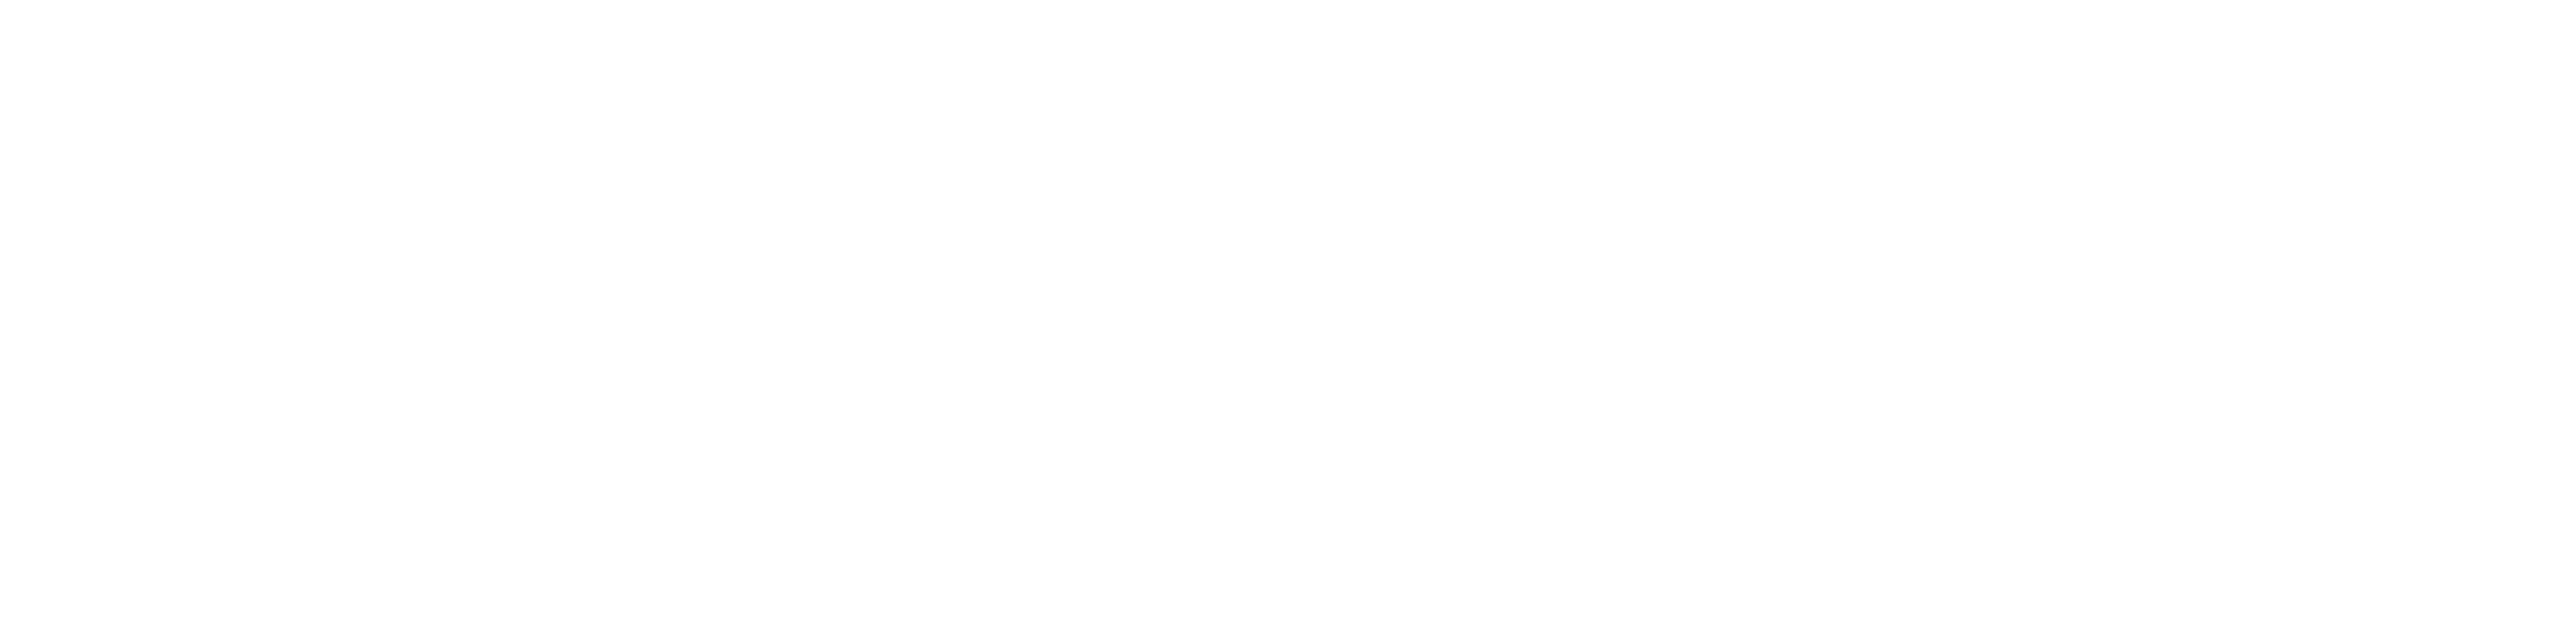

2020-06-16 17:19:19,634 logger INFO Fitting loss 0.212123, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050578, toSparseCloudLoss 0.109005, MemUsed:2228.38
2020-06-16 17:19:19,634 logger INFO Fitting loss 0.212123, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050578, toSparseCloudLoss 0.109005, MemUsed:2228.38
2020-06-16 17:19:19,634 logger INFO Fitting loss 0.212123, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050578, toSparseCloudLoss 0.109005, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


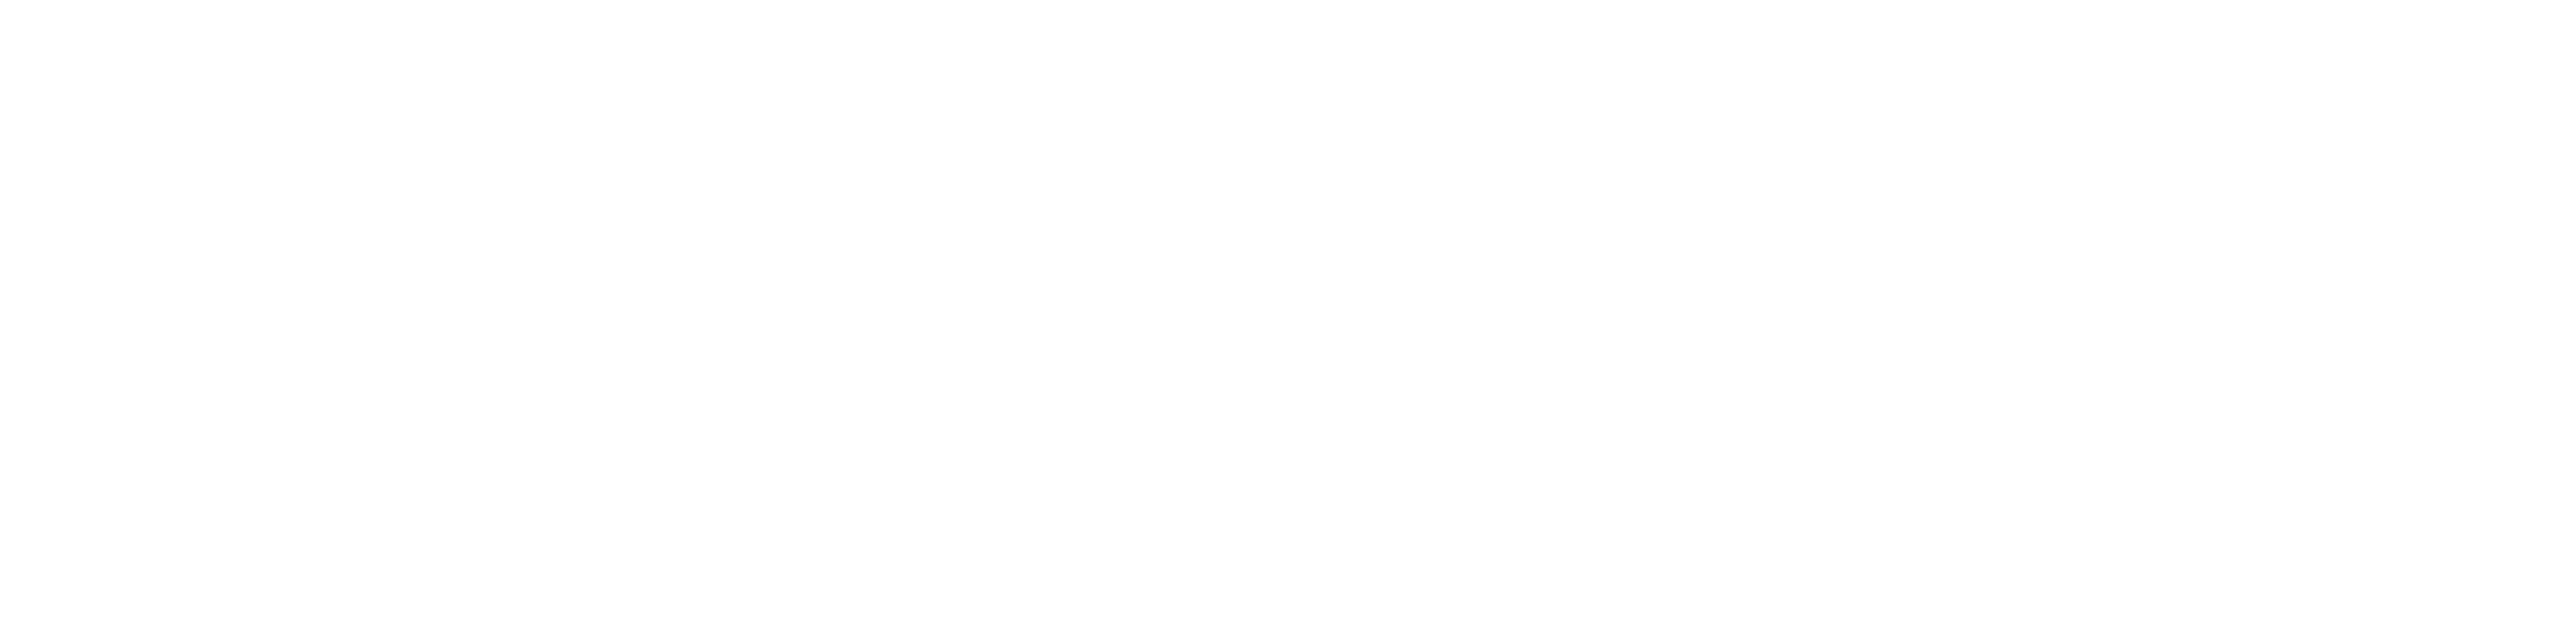

2020-06-16 17:19:42,143 logger INFO Fitting loss 0.211353, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050550, toSparseCloudLoss 0.108263, MemUsed:2228.38
2020-06-16 17:19:42,143 logger INFO Fitting loss 0.211353, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050550, toSparseCloudLoss 0.108263, MemUsed:2228.38
2020-06-16 17:19:42,143 logger INFO Fitting loss 0.211353, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050550, toSparseCloudLoss 0.108263, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


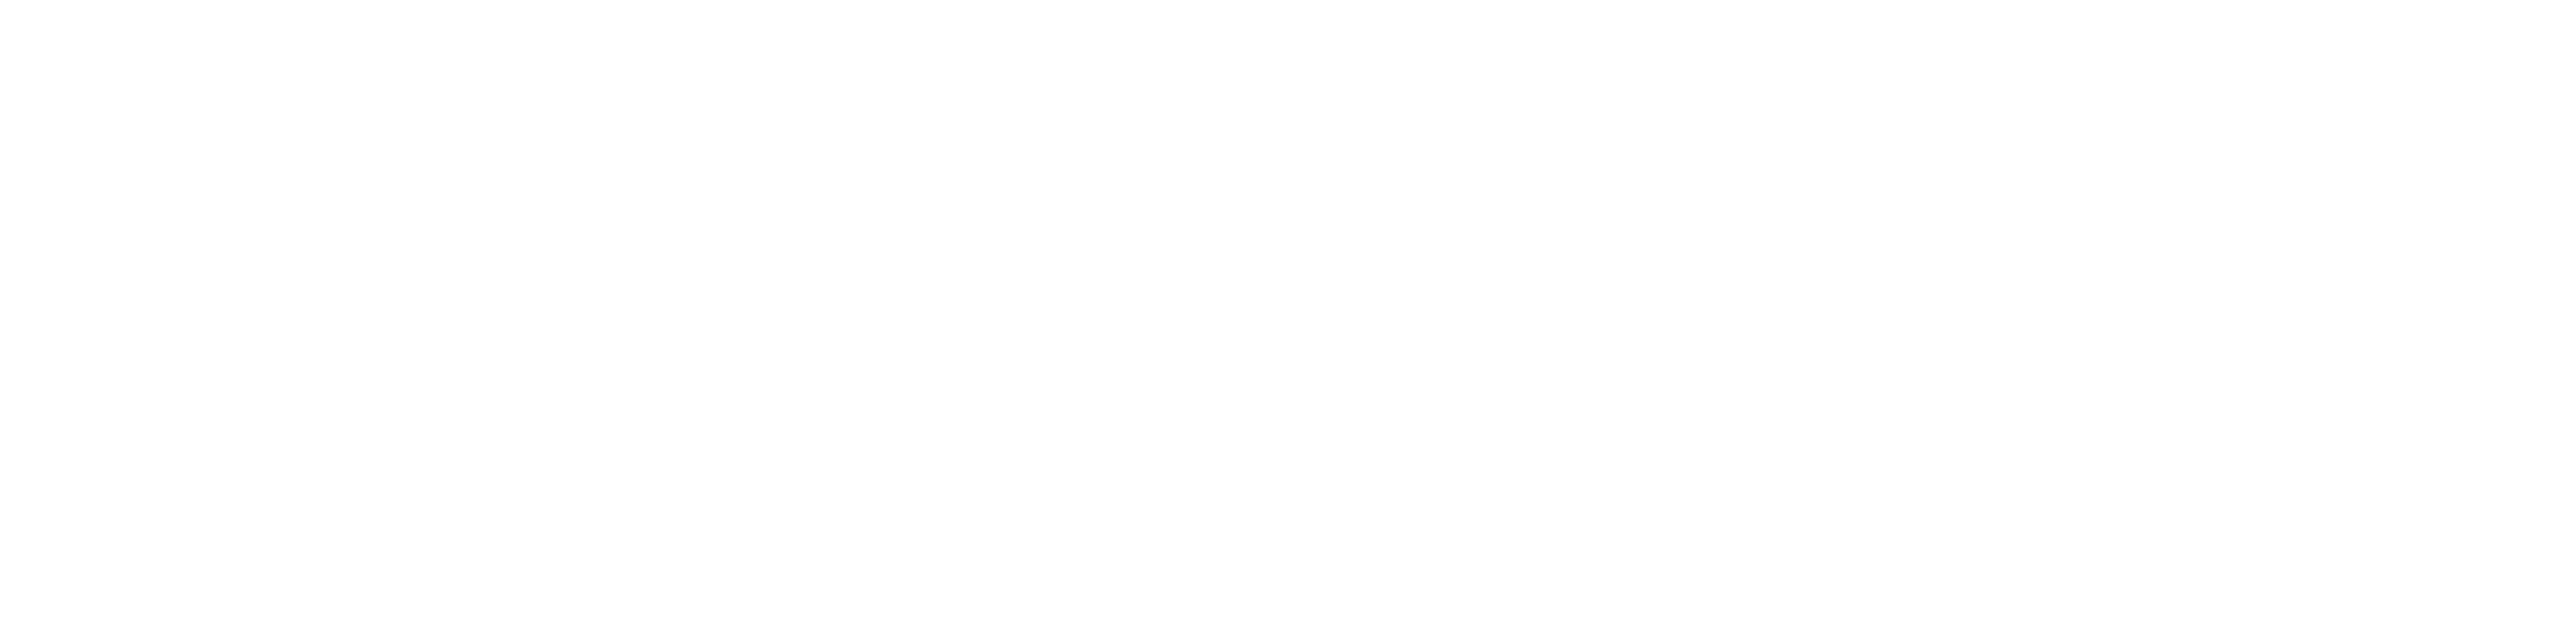

2020-06-16 17:20:04,644 logger INFO Fitting loss 0.210852, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050522, toSparseCloudLoss 0.107574, MemUsed:2228.38
2020-06-16 17:20:04,644 logger INFO Fitting loss 0.210852, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050522, toSparseCloudLoss 0.107574, MemUsed:2228.38
2020-06-16 17:20:04,644 logger INFO Fitting loss 0.210852, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050522, toSparseCloudLoss 0.107574, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


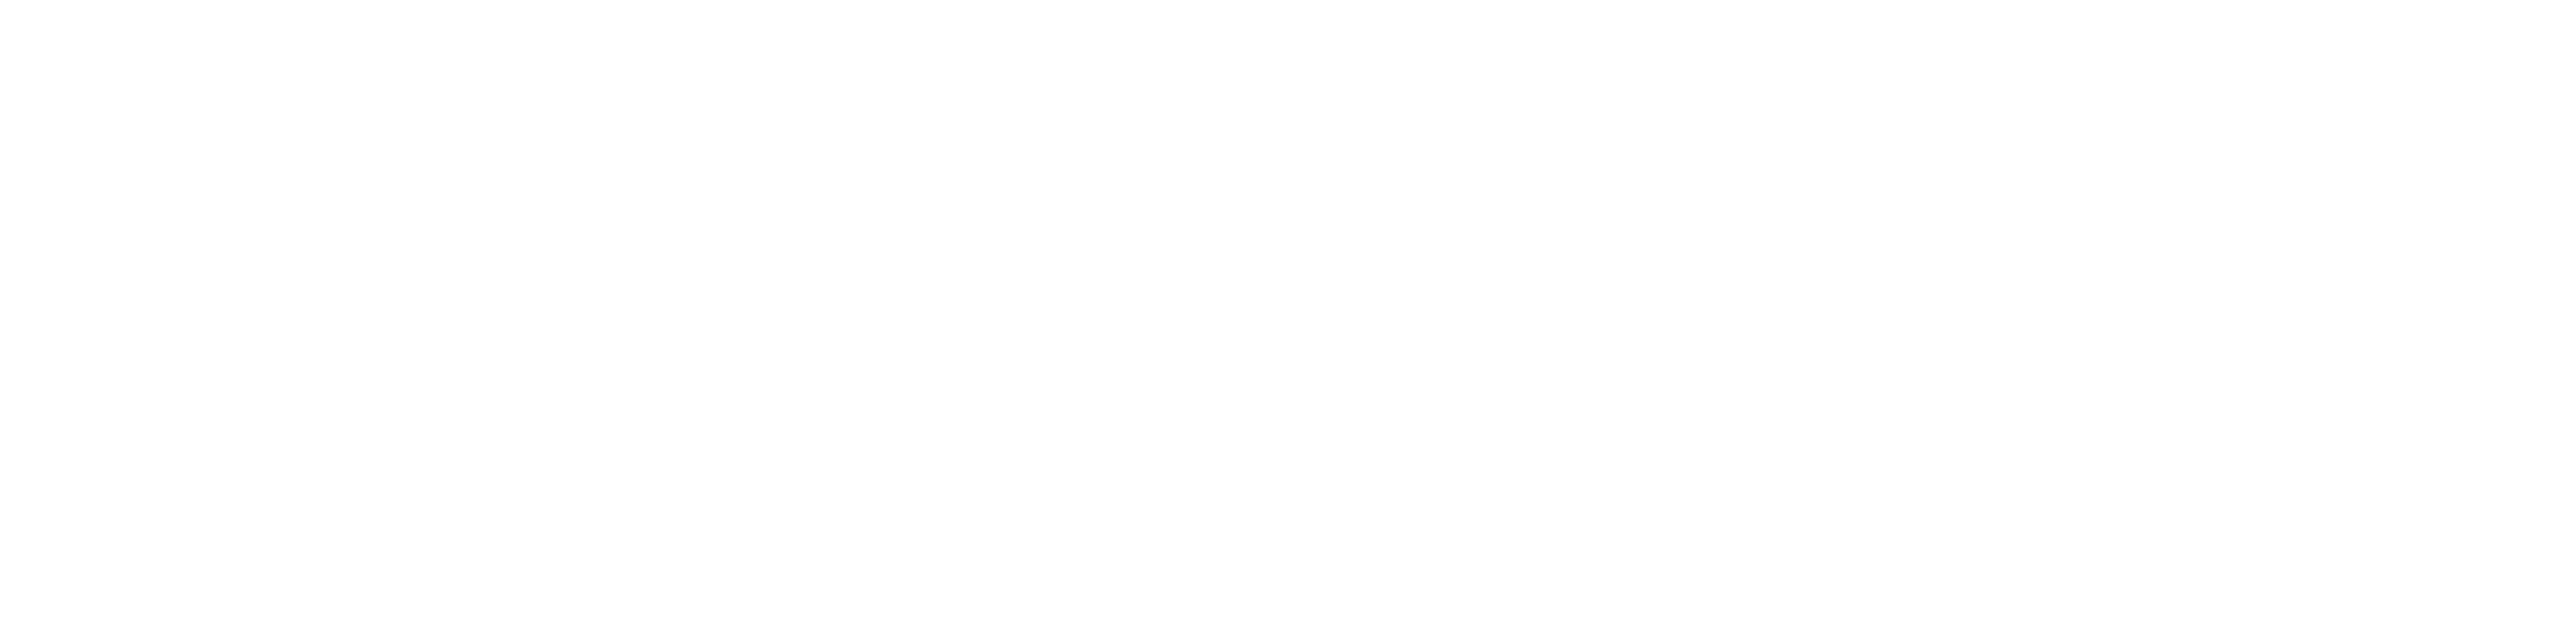

2020-06-16 17:20:27,027 logger INFO Fitting loss 0.210315, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050494, toSparseCloudLoss 0.106905, MemUsed:2228.38
2020-06-16 17:20:27,027 logger INFO Fitting loss 0.210315, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050494, toSparseCloudLoss 0.106905, MemUsed:2228.38
2020-06-16 17:20:27,027 logger INFO Fitting loss 0.210315, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050494, toSparseCloudLoss 0.106905, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


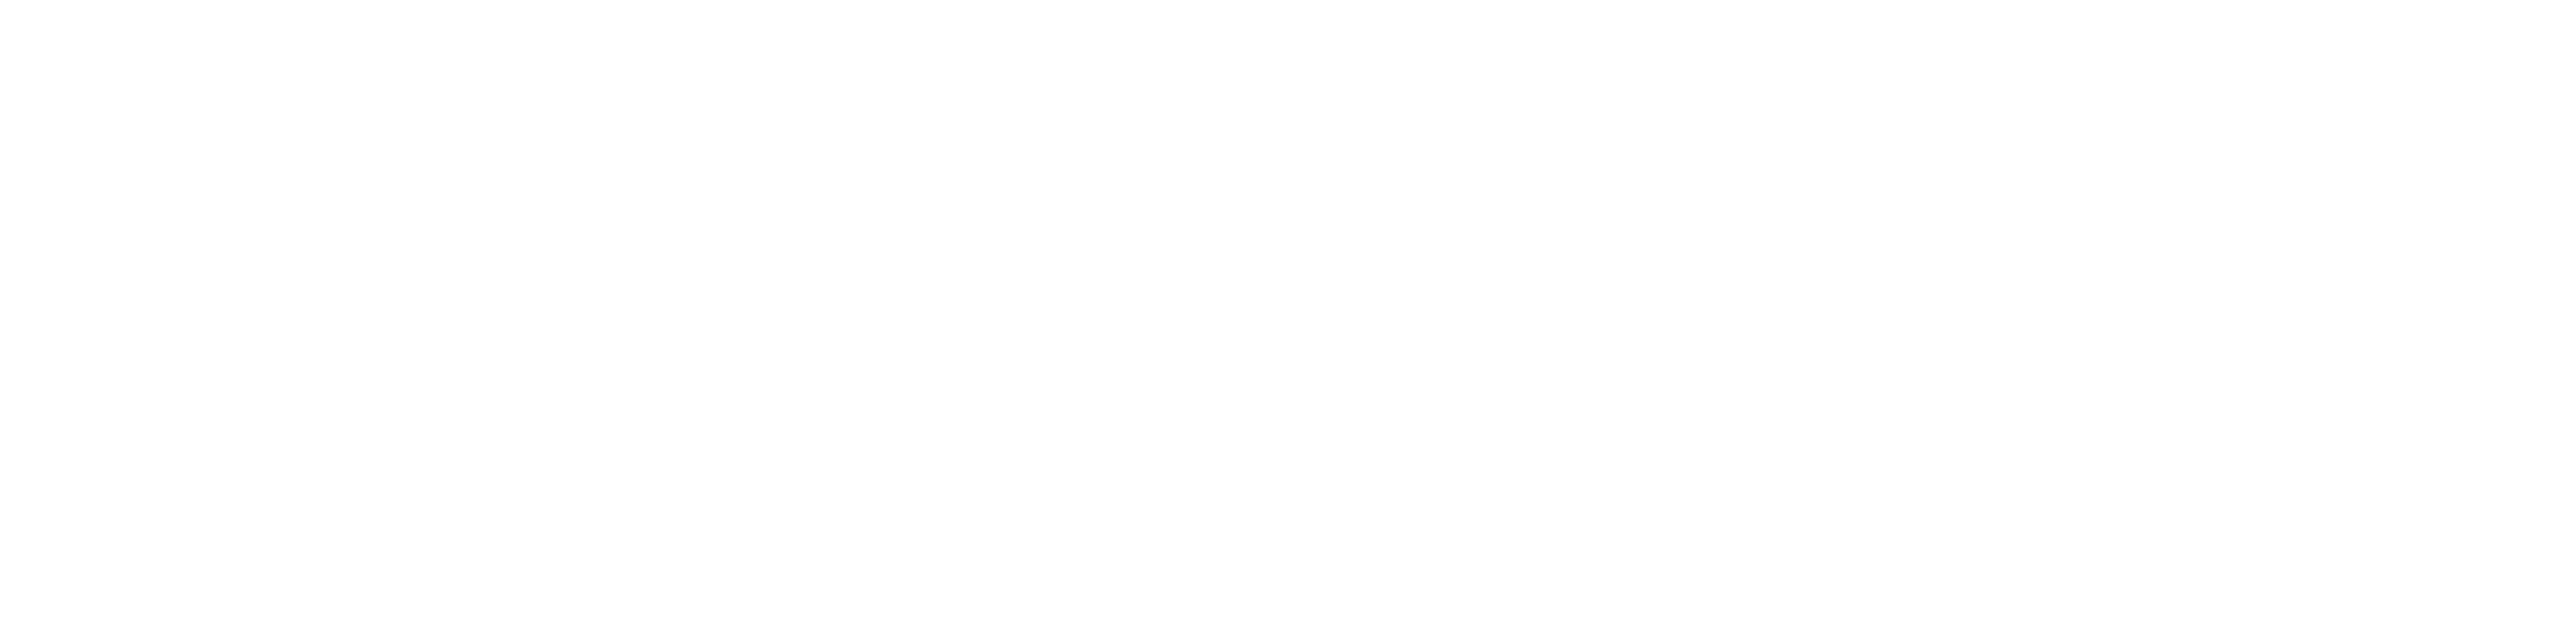

2020-06-16 17:20:49,613 logger INFO Fitting loss 0.209670, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050465, toSparseCloudLoss 0.106270, MemUsed:2228.38
2020-06-16 17:20:49,613 logger INFO Fitting loss 0.209670, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050465, toSparseCloudLoss 0.106270, MemUsed:2228.38
2020-06-16 17:20:49,613 logger INFO Fitting loss 0.209670, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050465, toSparseCloudLoss 0.106270, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


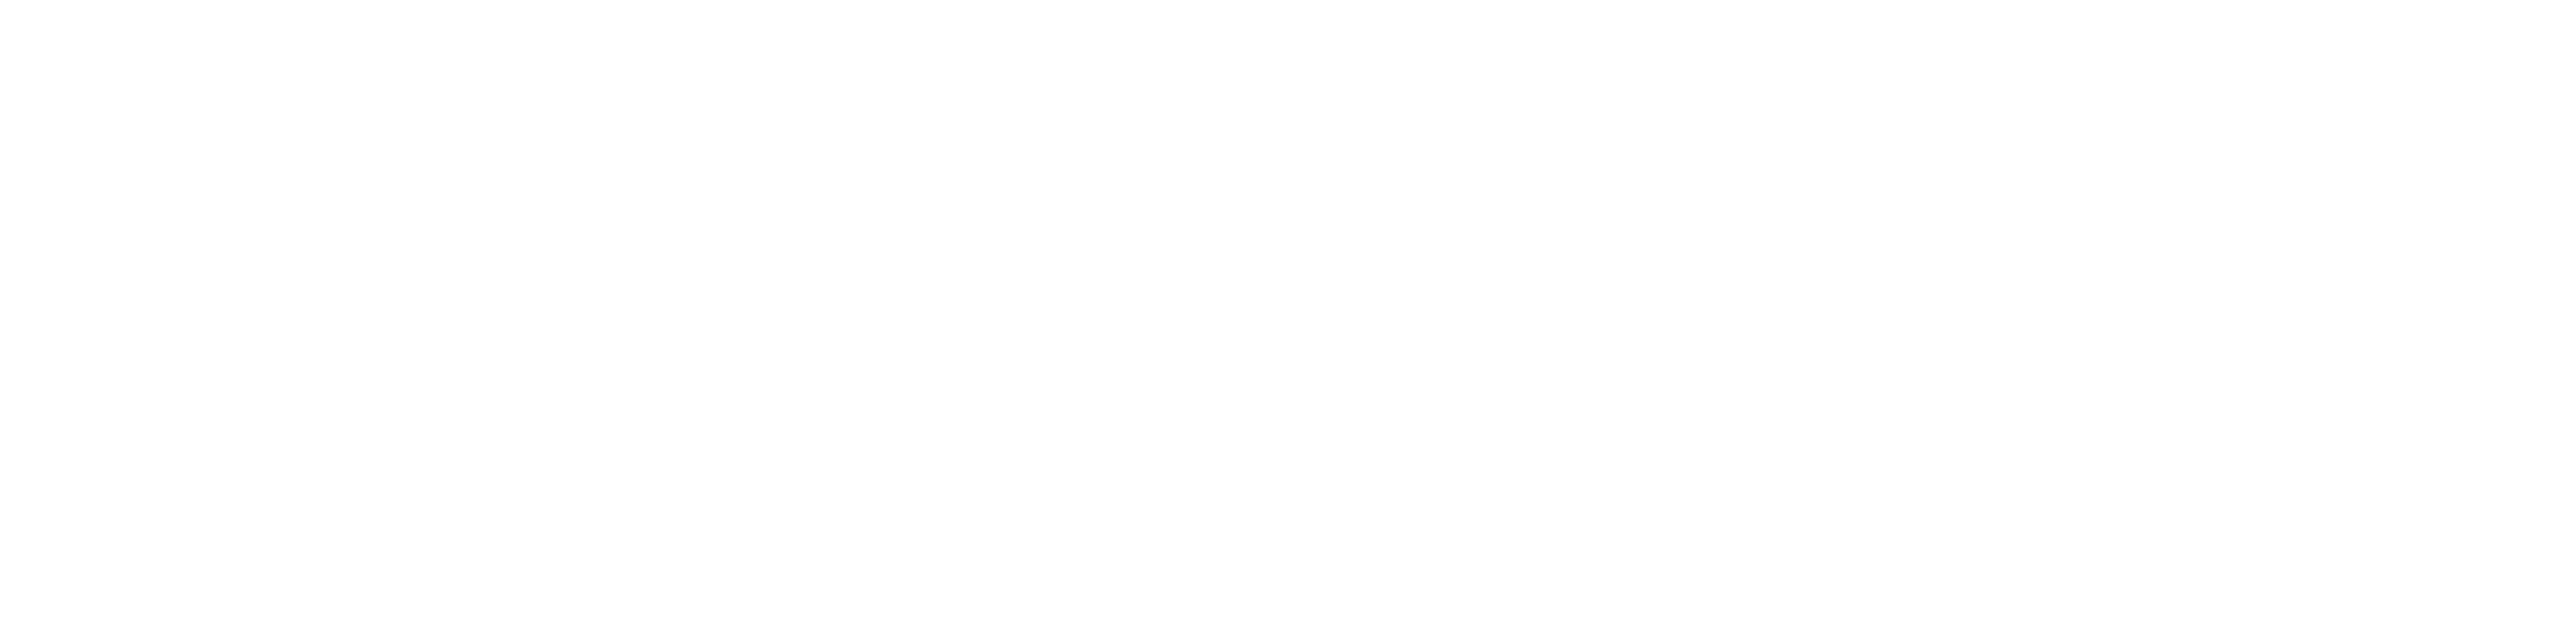

2020-06-16 17:21:12,130 logger INFO Fitting loss 0.208957, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050437, toSparseCloudLoss 0.105689, MemUsed:2228.38
2020-06-16 17:21:12,130 logger INFO Fitting loss 0.208957, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050437, toSparseCloudLoss 0.105689, MemUsed:2228.38
2020-06-16 17:21:12,130 logger INFO Fitting loss 0.208957, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050437, toSparseCloudLoss 0.105689, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


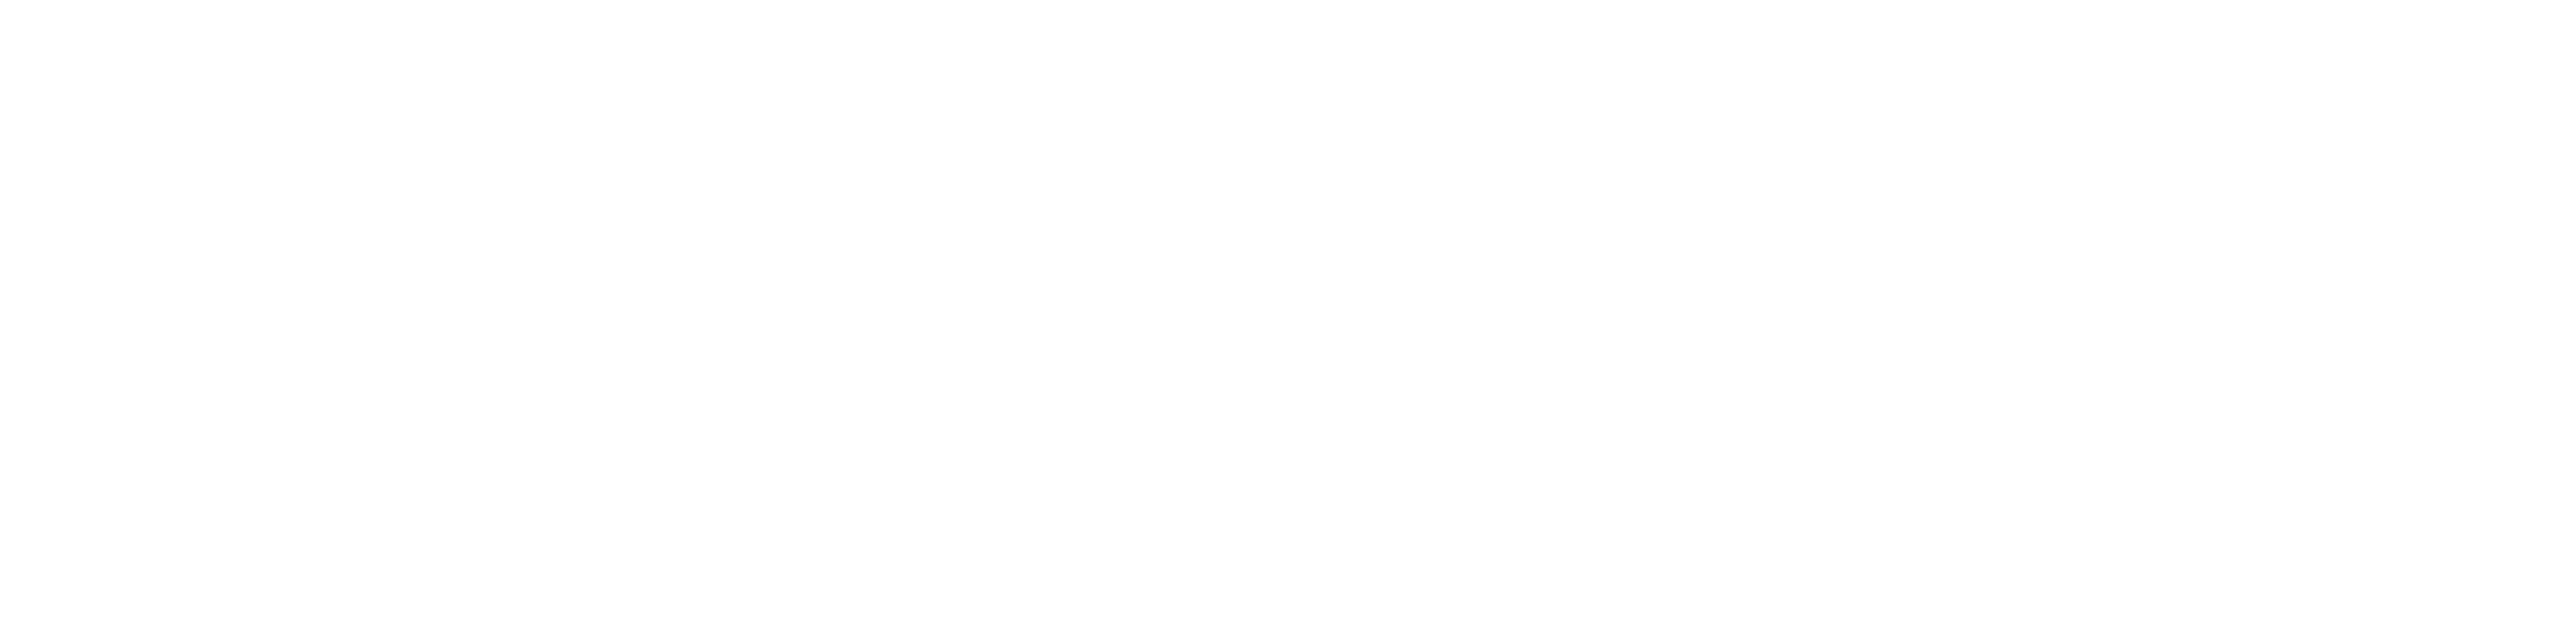

2020-06-16 17:21:34,626 logger INFO Fitting loss 0.208239, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050409, toSparseCloudLoss 0.105100, MemUsed:2228.38
2020-06-16 17:21:34,626 logger INFO Fitting loss 0.208239, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050409, toSparseCloudLoss 0.105100, MemUsed:2228.38
2020-06-16 17:21:34,626 logger INFO Fitting loss 0.208239, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050409, toSparseCloudLoss 0.105100, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


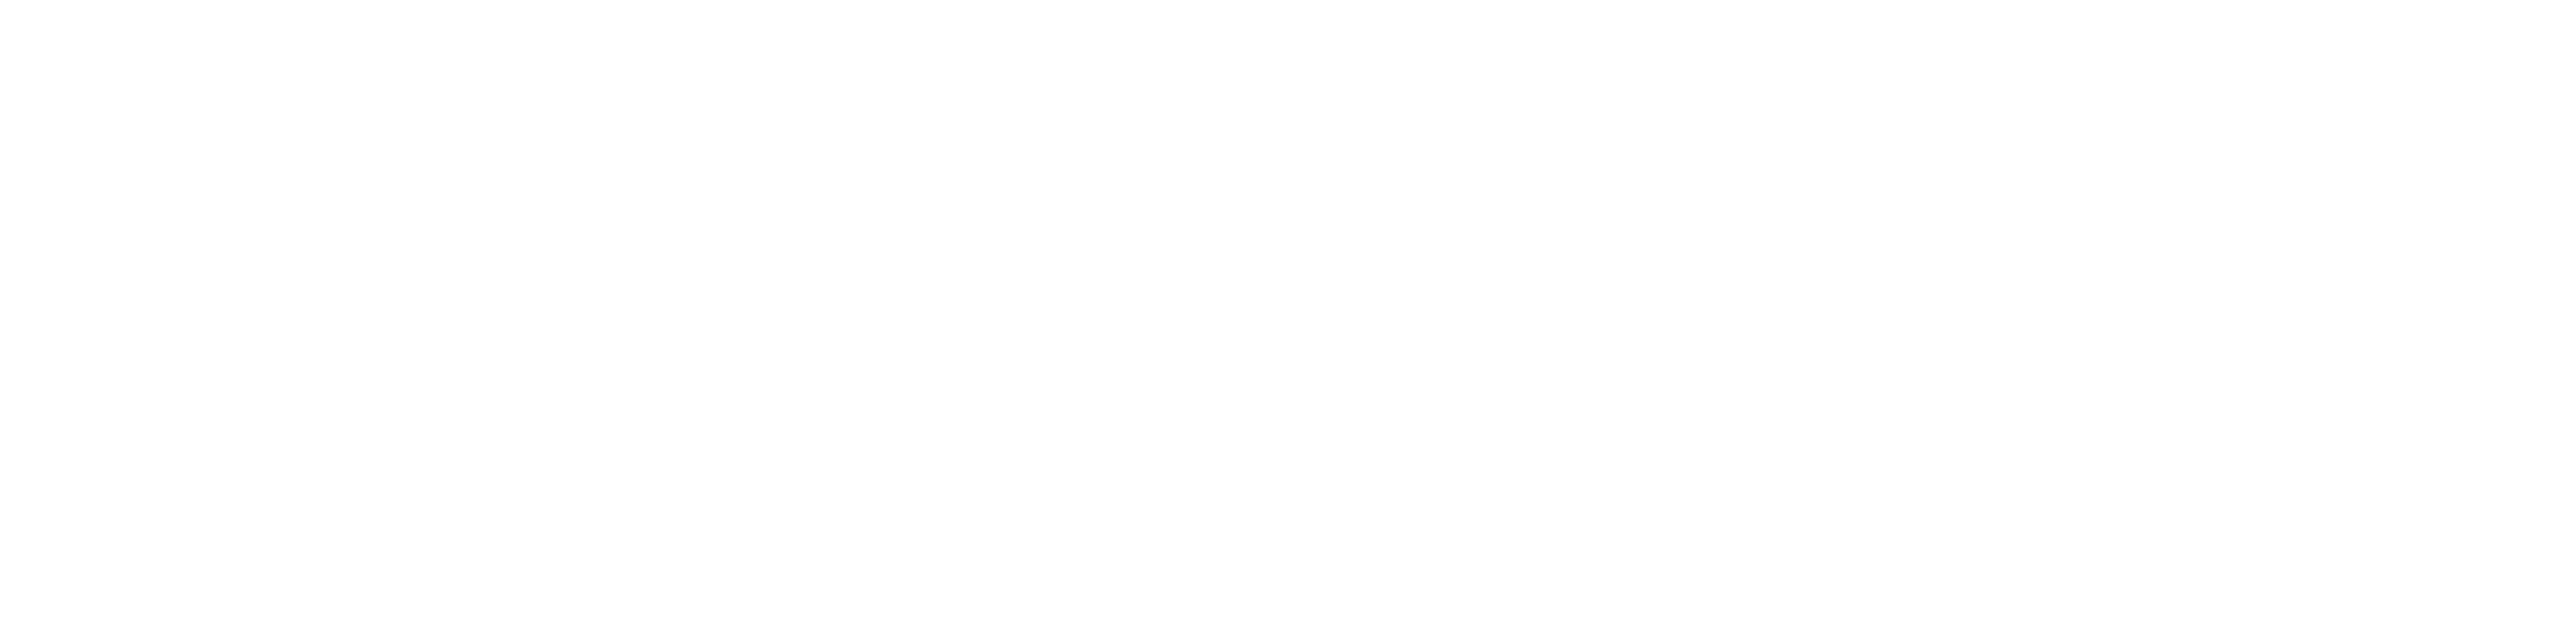

2020-06-16 17:21:57,124 logger INFO Fitting loss 0.207566, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050381, toSparseCloudLoss 0.104481, MemUsed:2228.38
2020-06-16 17:21:57,124 logger INFO Fitting loss 0.207566, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050381, toSparseCloudLoss 0.104481, MemUsed:2228.38
2020-06-16 17:21:57,124 logger INFO Fitting loss 0.207566, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050381, toSparseCloudLoss 0.104481, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


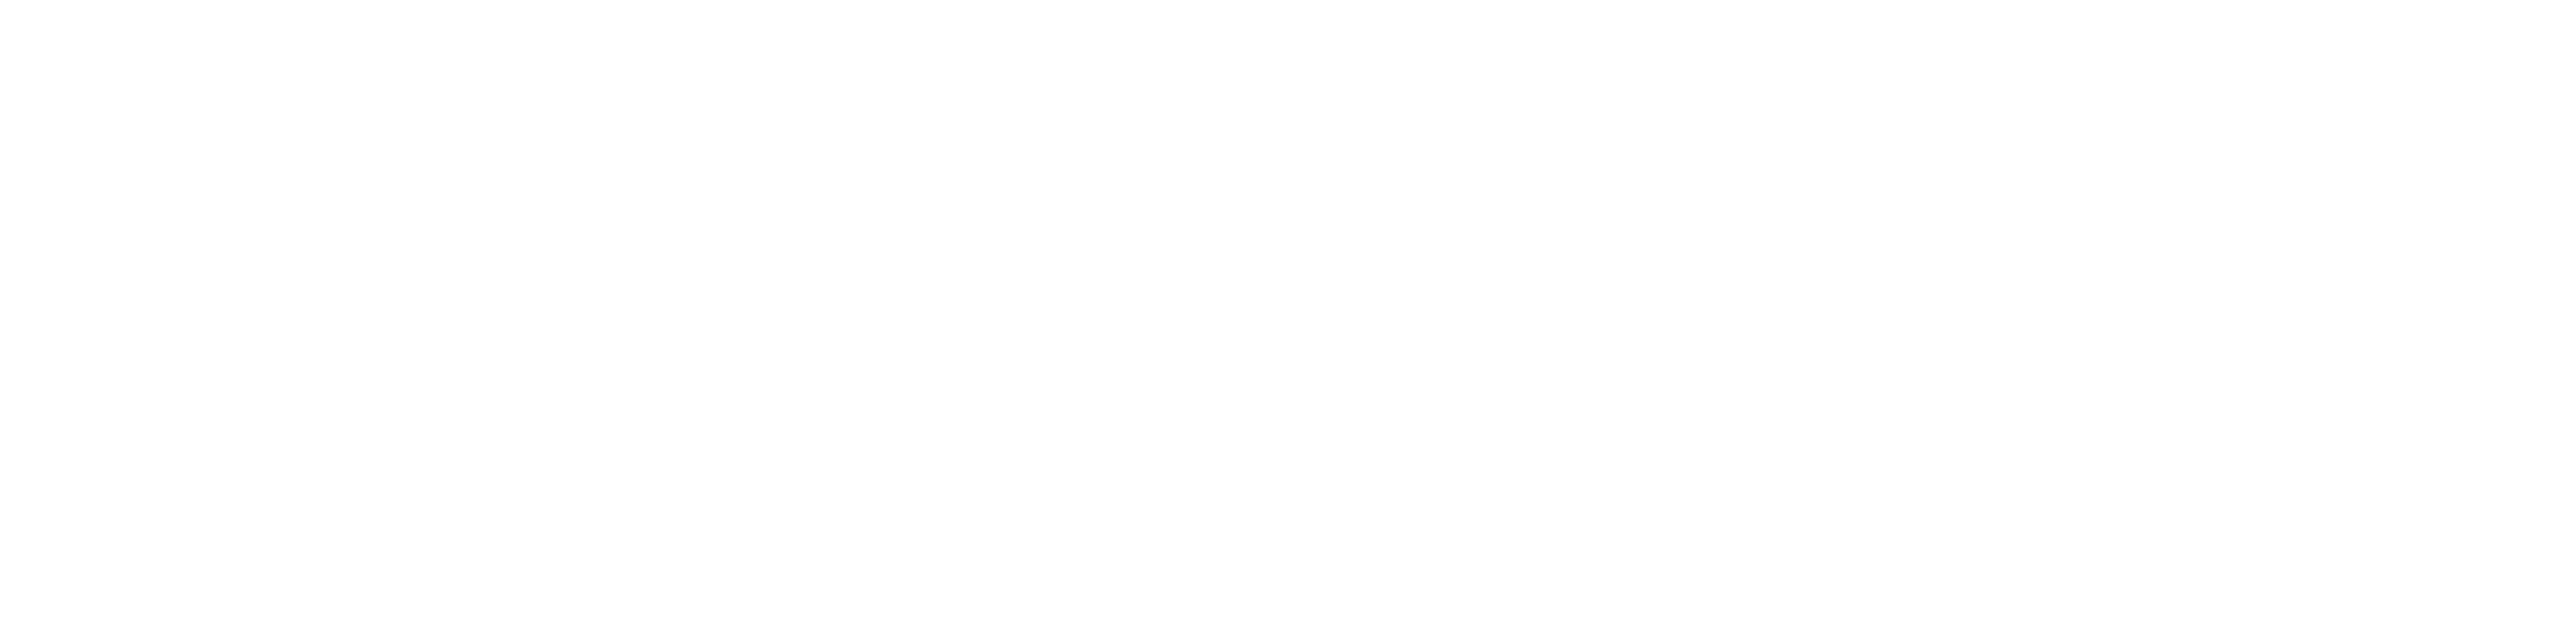

2020-06-16 17:22:19,534 logger INFO Fitting loss 0.207021, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050353, toSparseCloudLoss 0.103858, MemUsed:2228.38
2020-06-16 17:22:19,534 logger INFO Fitting loss 0.207021, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050353, toSparseCloudLoss 0.103858, MemUsed:2228.38
2020-06-16 17:22:19,534 logger INFO Fitting loss 0.207021, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050353, toSparseCloudLoss 0.103858, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


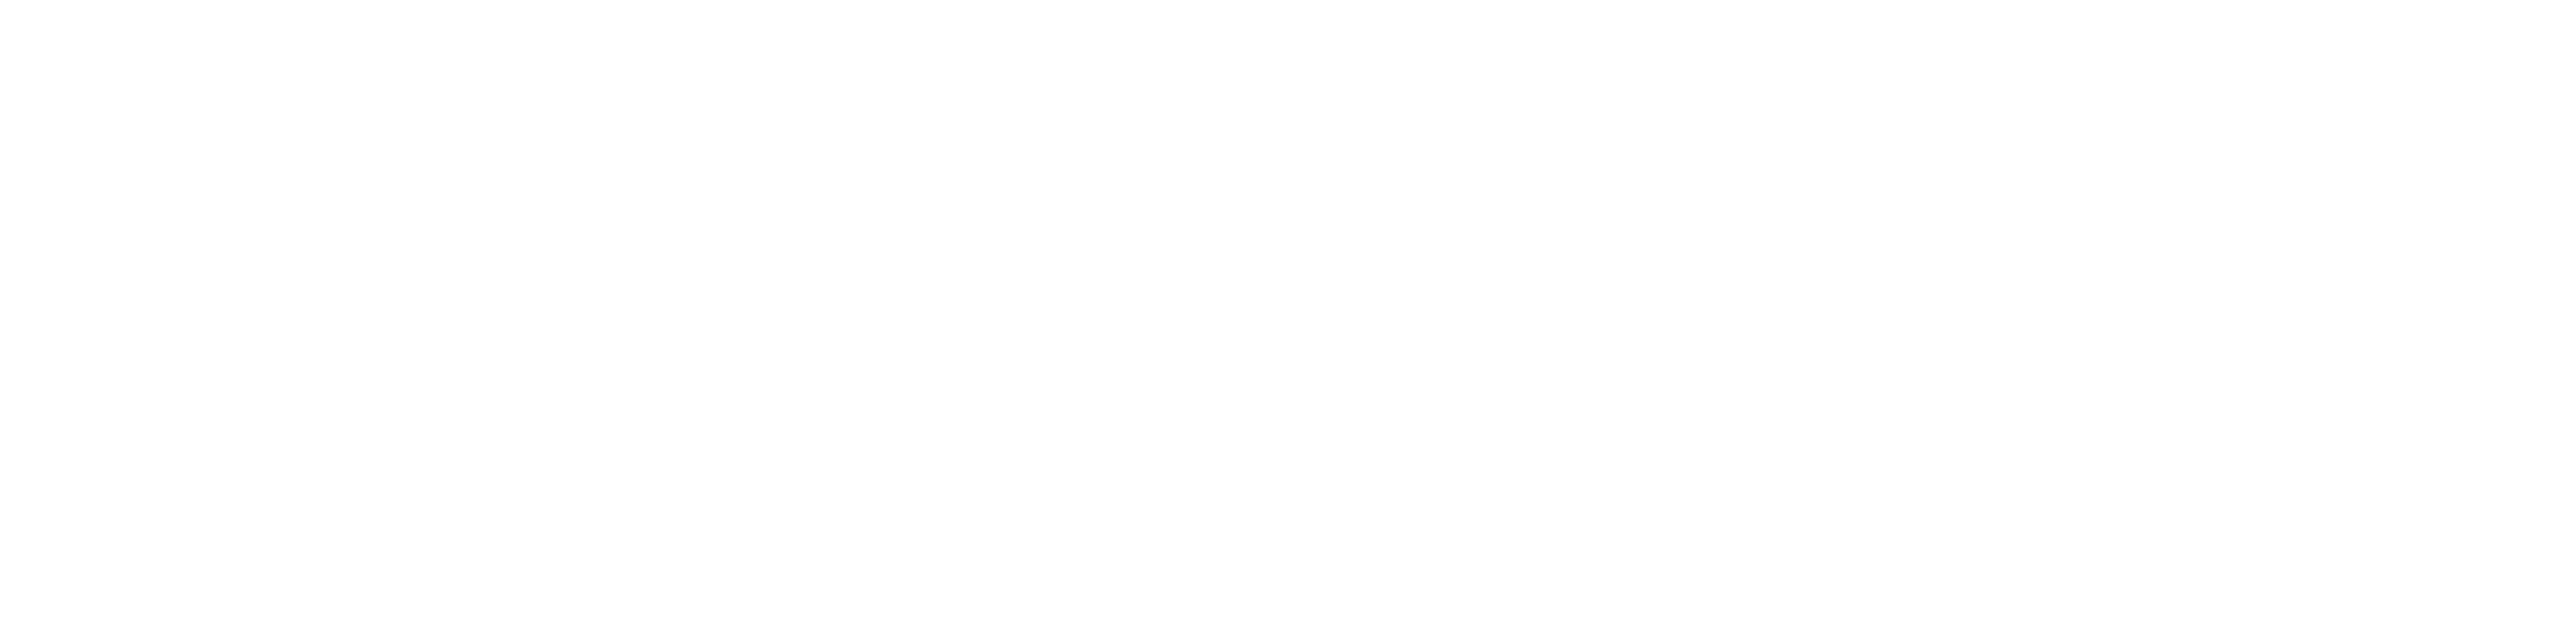

2020-06-16 17:22:42,094 logger INFO Fitting loss 0.206558, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050325, toSparseCloudLoss 0.103254, MemUsed:2228.38
2020-06-16 17:22:42,094 logger INFO Fitting loss 0.206558, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050325, toSparseCloudLoss 0.103254, MemUsed:2228.38
2020-06-16 17:22:42,094 logger INFO Fitting loss 0.206558, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050325, toSparseCloudLoss 0.103254, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


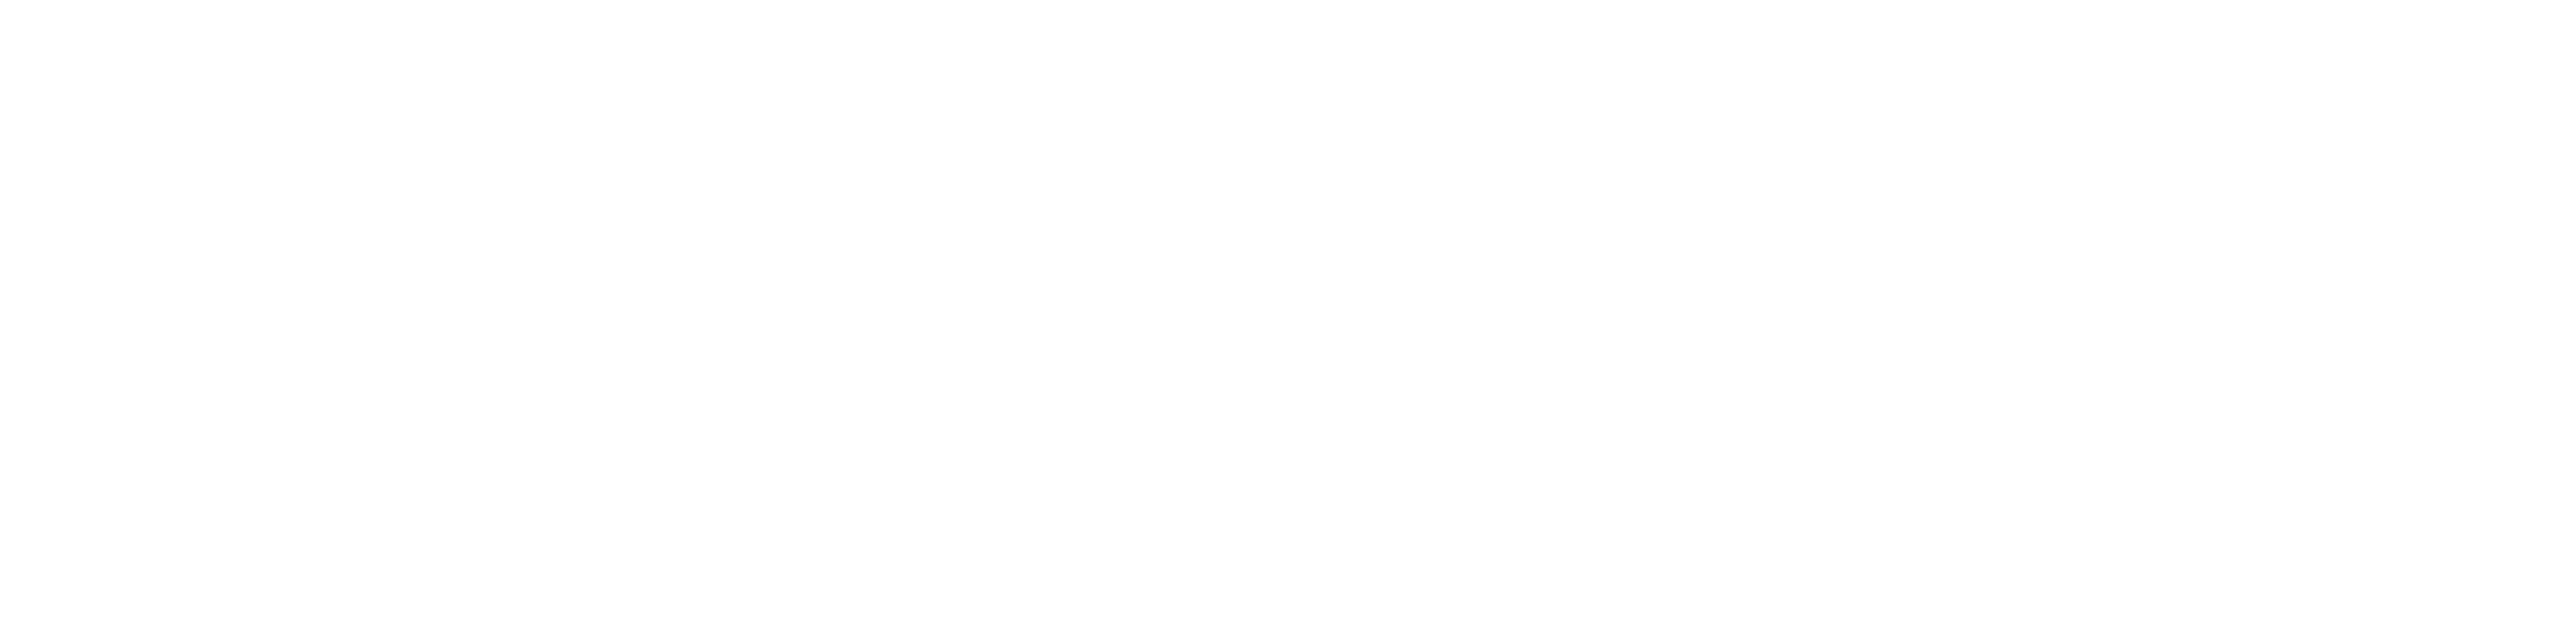

2020-06-16 17:23:04,608 logger INFO Fitting loss 0.206023, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050297, toSparseCloudLoss 0.102705, MemUsed:2228.38
2020-06-16 17:23:04,608 logger INFO Fitting loss 0.206023, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050297, toSparseCloudLoss 0.102705, MemUsed:2228.38
2020-06-16 17:23:04,608 logger INFO Fitting loss 0.206023, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050297, toSparseCloudLoss 0.102705, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


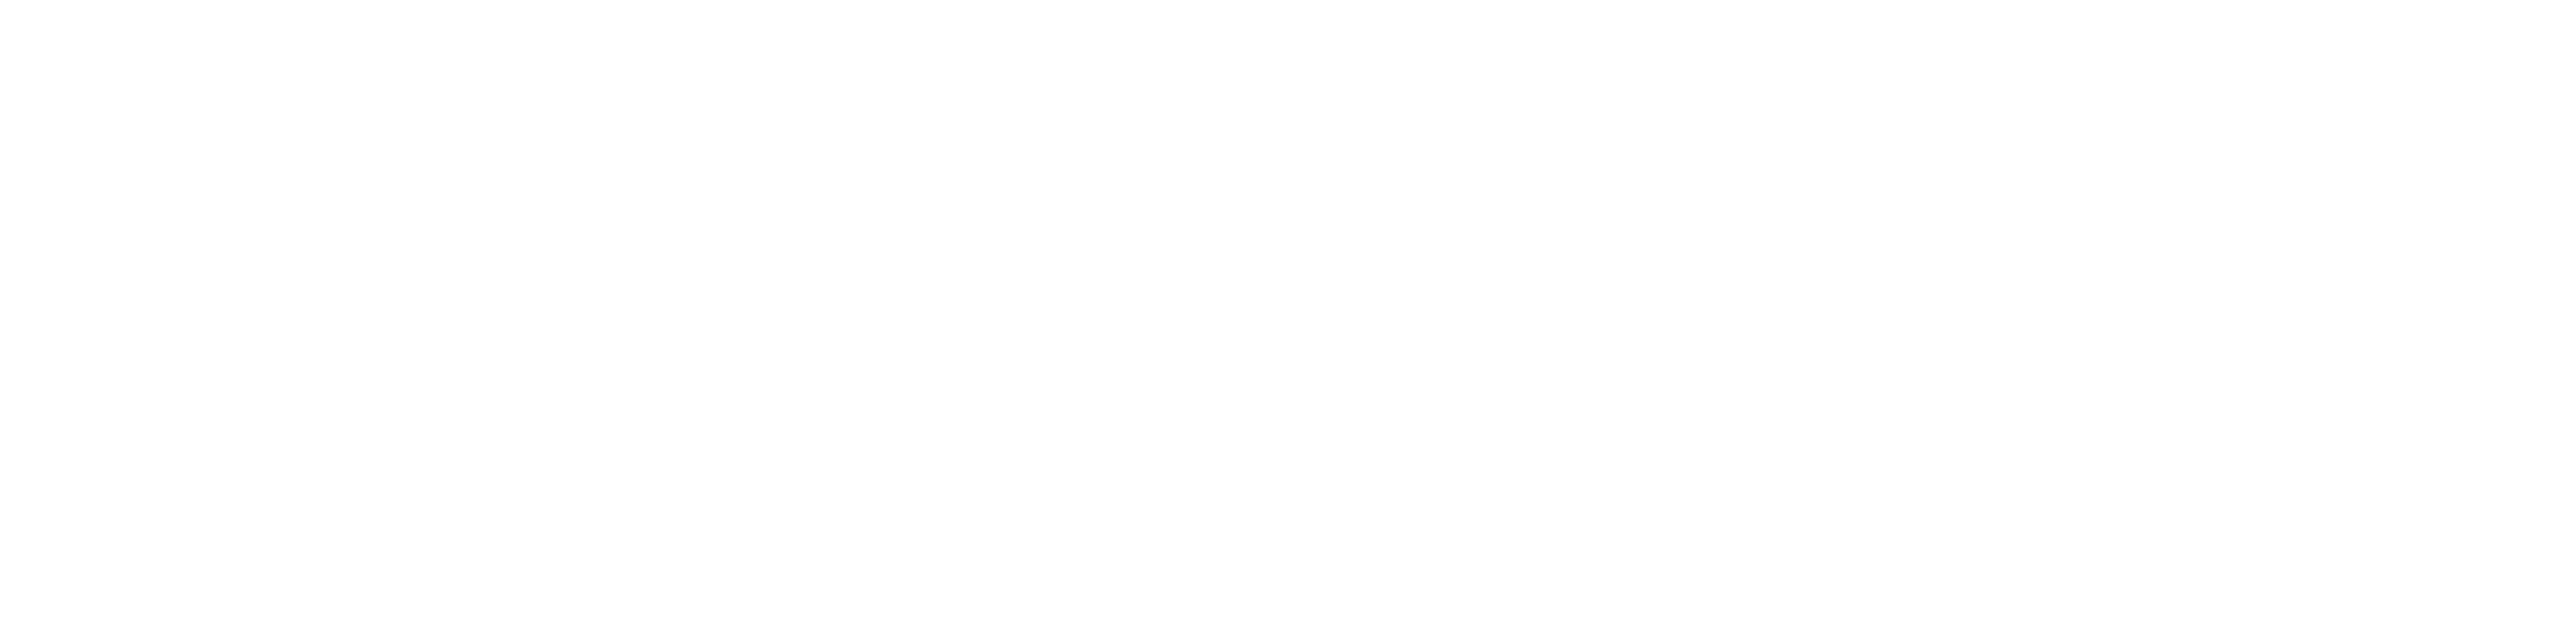

2020-06-16 17:23:27,069 logger INFO Fitting loss 0.205416, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050270, toSparseCloudLoss 0.102187, MemUsed:2228.38
2020-06-16 17:23:27,069 logger INFO Fitting loss 0.205416, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050270, toSparseCloudLoss 0.102187, MemUsed:2228.38
2020-06-16 17:23:27,069 logger INFO Fitting loss 0.205416, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050270, toSparseCloudLoss 0.102187, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


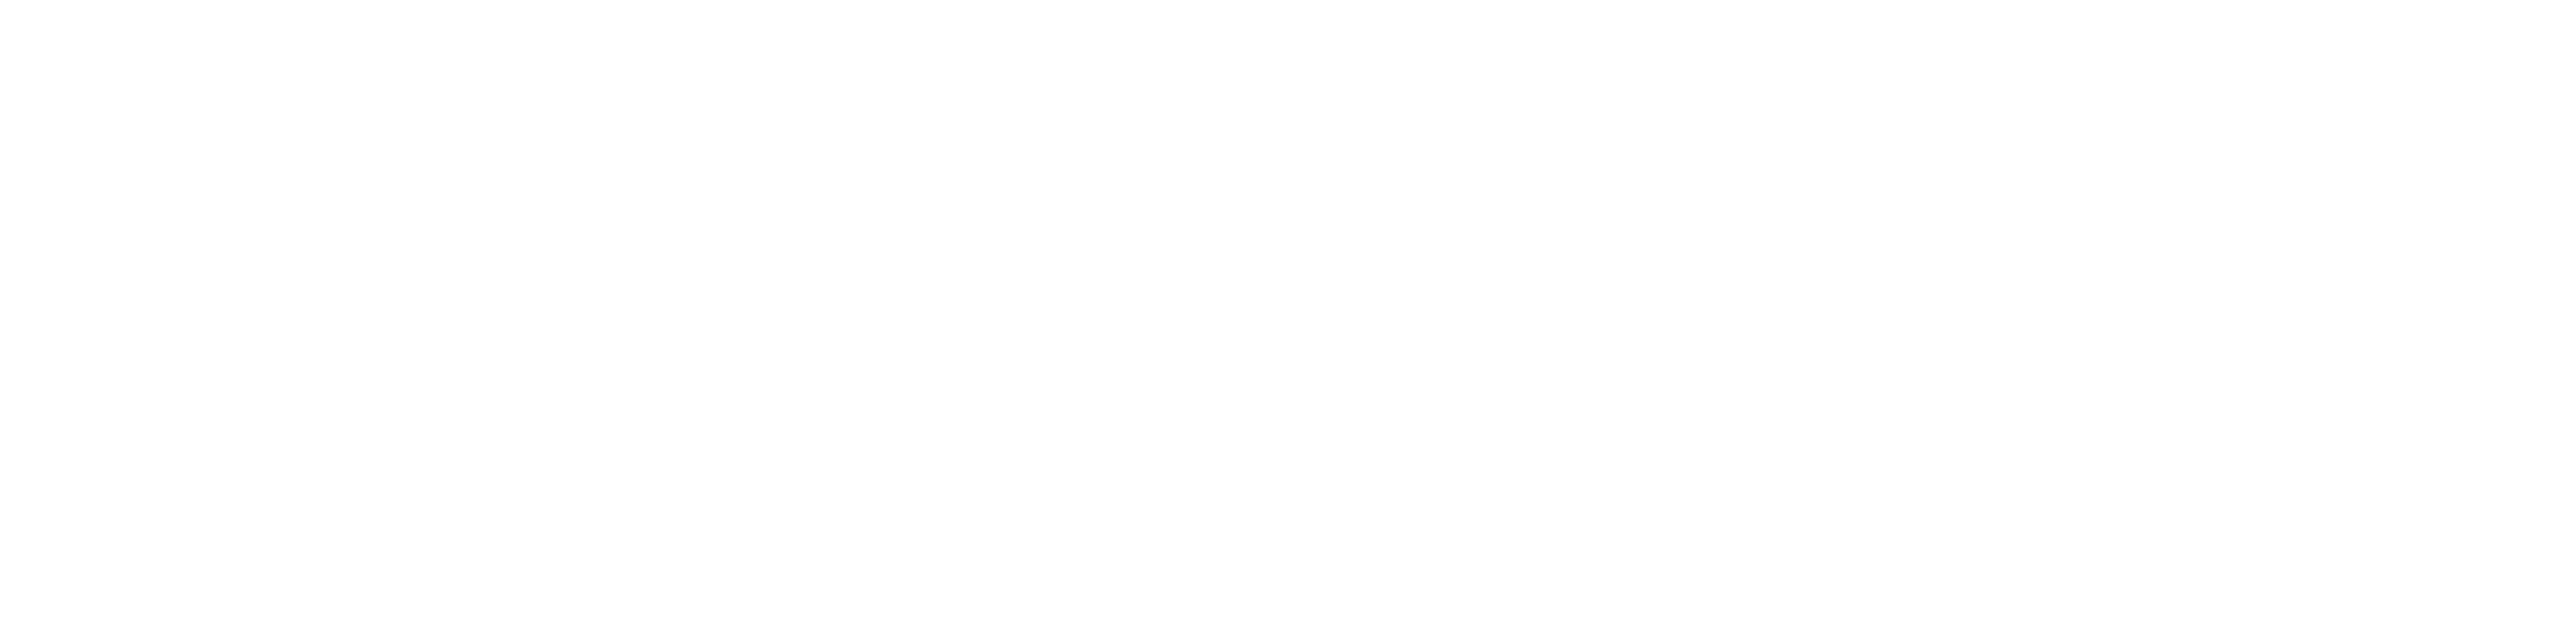

2020-06-16 17:23:49,594 logger INFO Fitting loss 0.204795, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050242, toSparseCloudLoss 0.101691, MemUsed:2228.38
2020-06-16 17:23:49,594 logger INFO Fitting loss 0.204795, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050242, toSparseCloudLoss 0.101691, MemUsed:2228.38
2020-06-16 17:23:49,594 logger INFO Fitting loss 0.204795, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050242, toSparseCloudLoss 0.101691, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>


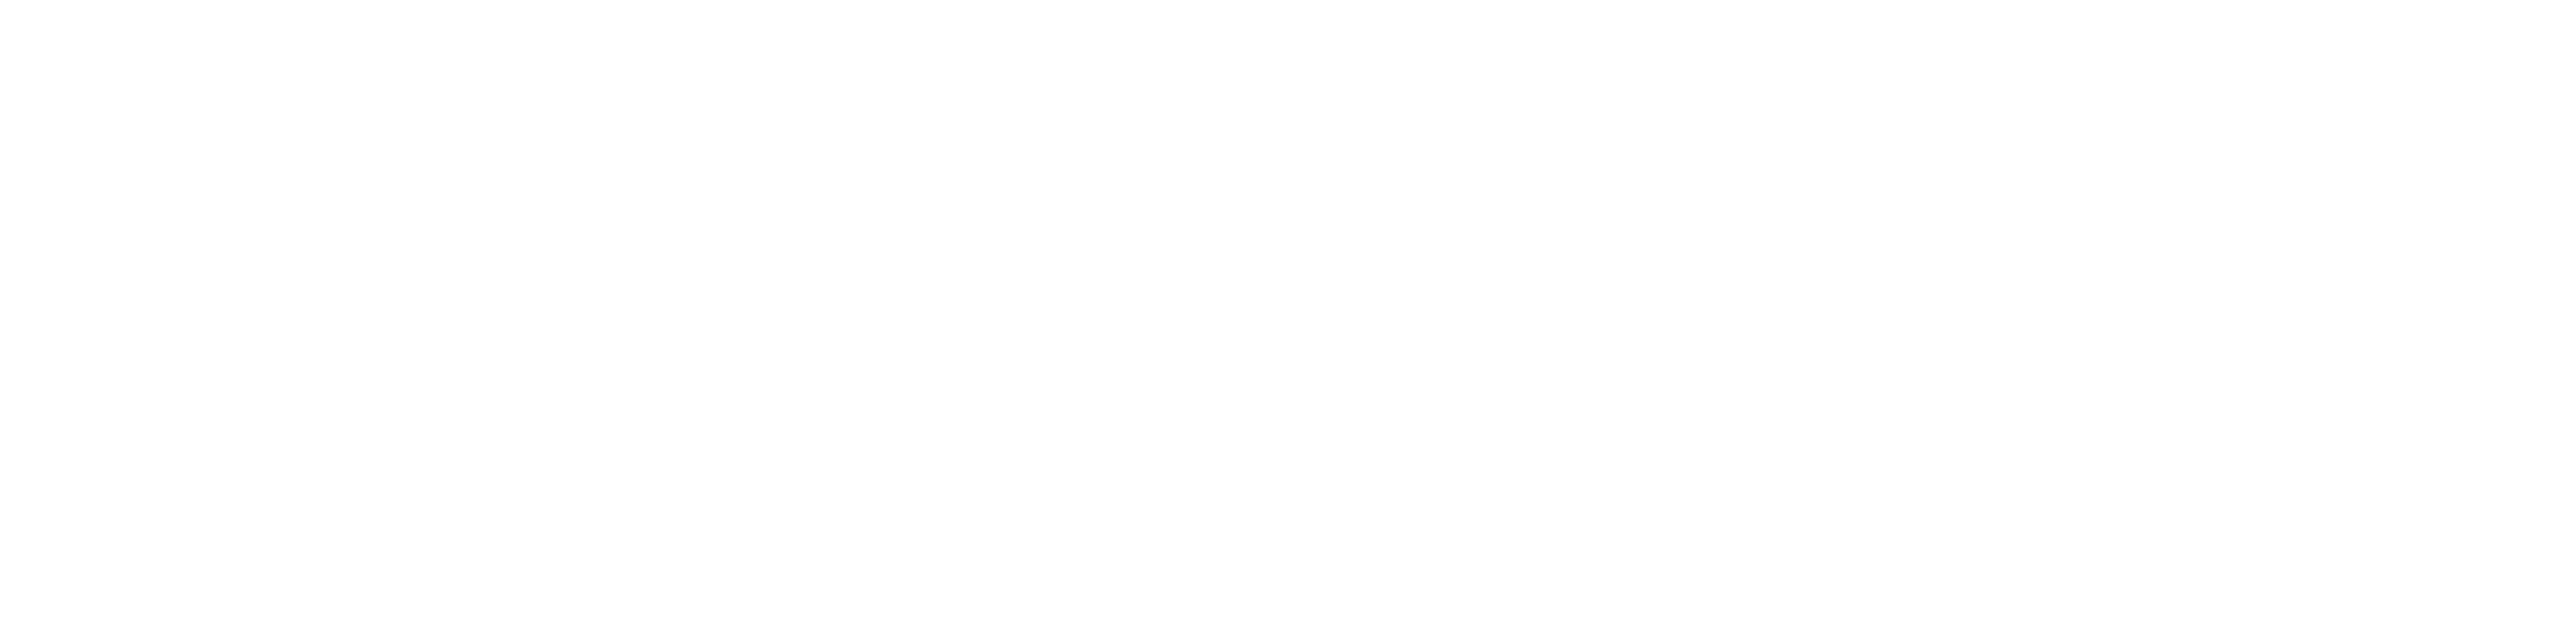

2020-06-16 17:24:12,172 logger INFO Fitting loss 0.204340, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050215, toSparseCloudLoss 0.101202, MemUsed:2228.38
2020-06-16 17:24:12,172 logger INFO Fitting loss 0.204340, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050215, toSparseCloudLoss 0.101202, MemUsed:2228.38
2020-06-16 17:24:12,172 logger INFO Fitting loss 0.204340, normal regularizer loss 0.000000, Laplacian regularizer loss 0.050215, toSparseCloudLoss 0.101202, MemUsed:2228.38
Before release: active_bytes.all.current: 2228.383232 MB
After release: active_bytes.all.current: 2228.383232 MB


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [78]:
cfg.numIterations = 300
loop = tqdm_notebook(range(cfg.numIterations))
# saveVTK(join(outFolderMesh, 'Target.vtk'), modifiedVertsRef.cpu().detach().numpy(), smplshExampleMesh)

fitParamFolder = join(outFolderForExperiment, 'FitParam')
os.makedirs(fitParamFolder, exist_ok=True)

imagesBatchRefs = []
for iCam in range(len(cams)):
    imagesBatchRef = crops_out[iCam*cfg.batchSize:iCam*cfg.batchSize + cfg.batchSize, ...,0]
    imagesBatchRef = torch.tensor(imagesBatchRef, dtype=torch.float32, device=device, requires_grad=False)
    imagesBatchRefs.append(imagesBatchRef)
        
for i in loop:
    optimizer.zero_grad()

    lossVal = 0
    for iCam in range(len(cams)):
        verts = smplsh(betas, pose, trans).type(torch.float32) 
#         modifiedVerts = verts + xyzShift
        mesh = Meshes(verts=[verts], faces=[smplsh.faces.to(device)],             )
        meshes = join_meshes_as_batch([mesh for i in range(cfg.batchSize)])
        imagesBatchRef = imagesBatchRefs[iCam]
        
        images = renderSynth.renderer(meshes, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss=0
        for iIm in range(cfg.batchSize):
            loss += (1 - torch.norm(imagesBatchRef[iIm, ...] * images[iIm, ..., 3], p=1) / torch.norm(imagesBatchRef[iIm, ...] + images[iIm, ..., 3] - imagesBatchRef[iIm, ...] * images[iIm, ..., 3], p=1))/cfg.numCams
        
        loss.backward()
        lossVal += loss.item()
        #showCudaMemUsage(device)
    
#     modifiedVerts = verts + xyzShift
    verts = smplsh(betas, pose, trans).type(torch.float32)
    mesh = Meshes(
                verts=[verts],   
                faces=[smplsh.faces.to(device)], 
#                 textures=textures.to(device)
            )
    
#     loss = cfg.lpSmootherW * mesh_laplacian_smoothing(mesh) + cfg.normalSmootherW * mesh_normal_consistency(mesh)
    loss = cfg.normalSmootherW * mesh_normal_consistency(mesh)
    normalSmootherVal = loss.item()
    loss = loss + cfg.lpSmootherW * xyzShift[:,0:1].transpose(0,1) @ LNP @ xyzShift[:,0:1]
    loss = loss + cfg.lpSmootherW * xyzShift[:,1:2].transpose(0,1) @ LNP @ xyzShift[:,1:2]
    loss = loss + cfg.lpSmootherW * xyzShift[:,2:3].transpose(0,1) @ LNP @ xyzShift[:,2:3]
    lpSmootherVal = loss.item() - normalSmootherVal
    
    loss.backward()
    lossVal += loss.item()
    # to corners loss
    verts = smplsh(betas, pose, trans).type(torch.float32) 
    loss = cfg.toSparseCornersFixingWeight * torch.sum((sparsePC - interpoMat @ verts)**2)
    loss.backward()
#     lossVal += loss.item()
    toSparseCloudLoss = loss.item()
    
    # fixing loss
    loss = torch.sum(xyzShift[indicesToFix, :]**2)
    loss.backward()
#     lossVal += loss.item()
    
    # recordData
    losses.append(lossVal)
    
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    torch.cuda.empty_cache()
    
    infoStr = 'Fitting loss %.6f, normal regularizer loss %.6f, Laplacian regularizer loss %.6f, toSparseCloudLoss %.6f, MemUsed:%.2f' \
        % (lossVal, normalSmootherVal, lpSmootherVal, toSparseCloudLoss, memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0 and i:
        showCudaMemUsage(device) 
        
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        diffImages = None
        with torch.no_grad():
            for  iCam in range(len(cams)):
                imagesBatchRef = crops_out[iCam*cfg.batchSize:iCam*cfg.batchSize + cfg.batchSize, ...,0]
                verts = smplsh(betas, pose, trans).type(torch.float32) 
                mesh = Meshes(verts=[verts], faces=[smplsh.faces.to(device)],             )
                meshes = join_meshes_as_batch([mesh for i in range(cfg.batchSize)])
                imagesBatch = renderSynth.renderer(meshes, cameras=cams[iCam]).cpu().numpy()[..., 3]

                imgDif = np.abs(imagesBatch - imagesBatchRef)
                if diffImages is not None:
                    diffImages = np.concatenate([diffImages, imgDif], axis=0)
                else:
                    diffImages = imgDif
#             loss += 1 -np.sum(np.abs(imagesBatch * imagesBatchRef)) / np.sum(np.abs(imagesBatchRef + imagesBatch - imagesBatchRef * imagesBatch))
#             showCudaMemUsage(device)
        
        outParamFile = join(fitParamFolder, 'Param_' + str(i).zfill(5) + '.npz')
        np.savez(outParamFile, trans = trans.cpu().detach().numpy(), pose=pose.cpu().detach().numpy(), 
                 beta=betas.cpu().detach().numpy(), personalShape = xyzShift.cpu().detach().numpy())
        visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5, pytorch3DImg=False)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), verts.cpu().detach().numpy(), smplshExampleMesh)


In [1]:
sparsePC - interpoMat @ verts

NameError: name 'sparsePC' is not defined

In [ ]:
saveVTK(join(outFolderForExperiment, 'FinalMesh.ply'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)

In [ ]:
def visualize2DSilhouetteResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                imgAlpha = images[iCam][0,...,3]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam]) * 0.5
#                     fgMask = np.logical_not(np.where())
#                     for iChannel in range(3):
                    img[..., 0] = img[..., 0] + imgAlpha * 0.5
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
images = []
outImgFile = join(outFolderForExperiment, 'FinalImage.png')
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())

visualize2DSilhouetteResults(images, backGroundImages = crops_out, outImgFile=outImgFile, sizeInInches=5)

In [ ]:
diffImages[0].shape

In [ ]:
np.max(diffImages[0])

In [ ]:
if True:
    showCudaMemUsage(device)
    modifiedVerts = verts + xyzShift
    mesh = Meshes(
            verts=[modifiedVerts],   
            faces=[faces_idx], 
        )
    
    torch.cuda.empty_cache()
    plt.close('all')
    
    outImgFile = join(outFolderForExperiment, 'Fig_' + str(0).zfill(5) + '.png')
    diffImages = []
    with torch.no_grad():
        for iCam in range(len(cams)):
            image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
            imgDiff =  np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
            diffImages.append(imgDiff)
    visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
    
    saveVTK(join(outFolderMesh, 'Fit' + str(0).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)